In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%%capture
!rm -rf /kaggle/working/miniconda
!wget -q https://repo.anaconda.com/miniconda/Miniconda3-py39_23.5.2-0-Linux-x86_64.sh -O miniconda.sh
!chmod +x miniconda.sh
!bash ./miniconda.sh -b -f -p /kaggle/working/miniconda
!rm miniconda.sh

# Verify Miniconda installation (check for python binary)
!ls -l /kaggle/working/miniconda/bin/python || echo "Python binary missing!"

# Ensure Conda binaries are executable
!chmod +x /kaggle/working/miniconda/bin/conda
!chmod +x /kaggle/working/miniconda/bin/python  # Explicitly make python executable
!chmod +x /kaggle/working/miniconda/etc/profile.d/conda.sh

In [3]:
# Add Conda to PATH
import os
os.environ['PATH'] = "/kaggle/working/miniconda/bin:" + os.environ['PATH']

In [4]:
%%capture
!conda install conda=25.1.1 -y

In [5]:
%%capture
# Initialize Conda
!conda init bash

# Create Conda environment with Python 3.9
!conda create -n p2w python=3.9 -y

In [6]:
!source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2w

In [7]:
%%capture
!conda install -n p2w mpi4py openmpi -y
!conda install -n p2w git -y
!pip install gdown

In [8]:
%%capture
!rm -rf /kaggle/working/p2w
# Git clone your repository
!git clone https://github.com/jychoi118/P2-weighting.git /kaggle/working/p2w

In [9]:
!conda info --envs
!python --version 

/kaggle/working/miniconda/lib/python3.9/site-packages/conda/base/context.py:202: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(

# conda environments:
#
base                   /kaggle/working/miniconda
p2w                    /kaggle/working/miniconda/envs/p2w

Python 3.9.17


In [10]:
test_install_code = '''import subprocess
import sys

def install(package_args):
    """Run a pip install command with support for extra arguments."""
    # Base command
    command = [sys.executable, "-m", "pip", "install"]
    # Split package_args into a list if it contains spaces (e.g., for --extra-index-url)
    args = package_args.split()
    # Extend command with all arguments
    command.extend(args)
    try:
        subprocess.check_call(command)
        print(f"Successfully installed: {' '.join(args)}")
    except subprocess.CalledProcessError as e:
        print(f"Error installing {' '.join(args)}: {e}")
        sys.exit(1)
# Install PyTorch and its ecosystem together to enforce consistency
#install("torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116")
install("torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 --extra-index-url https://download.pytorch.org/whl/cu121")
# Verify installation
# Install other packages (avoid upgrading torch)
packages = [
    "numpy==1.24.4",
    "pillow",
    "lpips",
    "torchmetrics==0.11.4",  # Pin to a version compatible with PyTorch 1.13.1
    "click",
    "scipy",
    "psutil",
    "requests",
    "tqdm",
    "blobfile",
    "imageio",
    "imageio-ffmpeg",
    "pyspng",
    "omegaconf",
    "pytorch_lightning==1.9.5",  # Pin to a version compatible with PyTorch 1.13.1
    "einops",
    "taming-transformers",
    "transformers"
]

for package in packages:
    install(package)

# Verify key installations
print("Verifying installations...")
try:
    import torch
    import numpy as np
    import torchvision
    import torchaudio
    import torchmetrics
    import pytorch_lightning
    print(f"Python version: {sys.version}")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"NCCL available: {torch.distributed.is_nccl_available()}")
    print(f"NumPy version: {np.__version__}")
    print(f"Torchvision version: {torchvision.__version__}")
    print(f"Torchaudio version: {torchaudio.__version__}")
    print(f"Torchmetrics version: {torchmetrics.__version__}")
    print(f"Pytorch Lightning version: {pytorch_lightning.__version__}")
except ImportError as e:
    print(f"Verification failed: {e}")
    sys.exit(1)'''
# Write the updated test_install.py to the cloned repo directory
with open('/kaggle/working/p2w/test_install.py', 'w') as f:
    f.write(test_install_code)

In [11]:
%%capture
!source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2w && \
cd /kaggle/working/p2w && python test_install.py

In [12]:
!mkdir -p /kaggle/working/p2w/logs
!mkdir -p /kaggle/working/p2w/checkpoints
!mkdir -p /kaggle/working/p2w/training_amed
!mkdir -p /kaggle/working/p2w/exps
!mkdir -p /kaggle/working/p2w/src
!mkdir -p /kaggle/working/p2w/torch_utils

In [13]:
!mkdir -p /kaggle/working/p2w/dnnlib
!mkdir -p /kaggle/working/p2w/ldm

In [14]:
init='''
# Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# You should have received a copy of the license along with this
# work. If not, see http://creativecommons.org/licenses/by-nc-sa/4.0/

from .util import EasyDict, make_cache_dir_path
'''
with open('/kaggle/working/p2w/dnnlib/__init__.py', 'w') as f:
    f.write(init)
print("Successfully wrote init.py to /kaggle/working/p2w/dnnlib/__init__.py")

Successfully wrote init.py to /kaggle/working/p2w/dnnlib/__init__.py


our ema 0.9999hceckpoints use_fp16=True

In [15]:
dnnlib='''
# Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# You should have received a copy of the license along with this
# work. If not, see http://creativecommons.org/licenses/by-nc-sa/4.0/

"""Miscellaneous utility classes and functions."""

import ctypes
import fnmatch
import importlib
import inspect
import numpy as np
import os
import shutil
import sys
import types
import io
import pickle
import re
import requests
import html
import hashlib
import glob
import tempfile
import urllib
import urllib.request
import uuid

from distutils.util import strtobool
from typing import Any, List, Tuple, Union, Optional


# Util classes
# ------------------------------------------------------------------------------------------


class EasyDict(dict):
    """Convenience class that behaves like a dict but allows access with the attribute syntax."""

    def __getattr__(self, name: str) -> Any:
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

    def __setattr__(self, name: str, value: Any) -> None:
        self[name] = value

    def __delattr__(self, name: str) -> None:
        del self[name]


class Logger(object):
    """Redirect stderr to stdout, optionally print stdout to a file, and optionally force flushing on both stdout and the file."""

    def __init__(self, file_name: Optional[str] = None, file_mode: str = "w", should_flush: bool = True):
        self.file = None

        if file_name is not None:
            self.file = open(file_name, file_mode)

        self.should_flush = should_flush
        self.stdout = sys.stdout
        self.stderr = sys.stderr

        sys.stdout = self
        sys.stderr = self

    def __enter__(self) -> "Logger":
        return self

    def __exit__(self, exc_type: Any, exc_value: Any, traceback: Any) -> None:
        self.close()

    def write(self, text: Union[str, bytes]) -> None:
        """Write text to stdout (and a file) and optionally flush."""
        if isinstance(text, bytes):
            text = text.decode()
        if len(text) == 0: # workaround for a bug in VSCode debugger: sys.stdout.write(''); sys.stdout.flush() => crash
            return

        if self.file is not None:
            self.file.write(text)

        self.stdout.write(text)

        if self.should_flush:
            self.flush()

    def flush(self) -> None:
        """Flush written text to both stdout and a file, if open."""
        if self.file is not None:
            self.file.flush()

        self.stdout.flush()

    def close(self) -> None:
        """Flush, close possible files, and remove stdout/stderr mirroring."""
        self.flush()

        # if using multiple loggers, prevent closing in wrong order
        if sys.stdout is self:
            sys.stdout = self.stdout
        if sys.stderr is self:
            sys.stderr = self.stderr

        if self.file is not None:
            self.file.close()
            self.file = None


# Cache directories
# ------------------------------------------------------------------------------------------

_dnnlib_cache_dir = None

def set_cache_dir(path: str) -> None:
    global _dnnlib_cache_dir
    _dnnlib_cache_dir = path

def make_cache_dir_path(*paths: str) -> str:
    if _dnnlib_cache_dir is not None:
        return os.path.join(_dnnlib_cache_dir, *paths)
    if 'DNNLIB_CACHE_DIR' in os.environ:
        return os.path.join(os.environ['DNNLIB_CACHE_DIR'], *paths)
    if 'HOME' in os.environ:
        return os.path.join(os.environ['HOME'], '.cache', 'dnnlib', *paths)
    if 'USERPROFILE' in os.environ:
        return os.path.join(os.environ['USERPROFILE'], '.cache', 'dnnlib', *paths)
    return os.path.join(tempfile.gettempdir(), '.cache', 'dnnlib', *paths)

# Small util functions
# ------------------------------------------------------------------------------------------


def format_time(seconds: Union[int, float]) -> str:
    """Convert the seconds to human readable string with days, hours, minutes and seconds."""
    s = int(np.rint(seconds))

    if s < 60:
        return "{0}s".format(s)
    elif s < 60 * 60:
        return "{0}m {1:02}s".format(s // 60, s % 60)
    elif s < 24 * 60 * 60:
        return "{0}h {1:02}m {2:02}s".format(s // (60 * 60), (s // 60) % 60, s % 60)
    else:
        return "{0}d {1:02}h {2:02}m".format(s // (24 * 60 * 60), (s // (60 * 60)) % 24, (s // 60) % 60)


def format_time_brief(seconds: Union[int, float]) -> str:
    """Convert the seconds to human readable string with days, hours, minutes and seconds."""
    s = int(np.rint(seconds))

    if s < 60:
        return "{0}s".format(s)
    elif s < 60 * 60:
        return "{0}m {1:02}s".format(s // 60, s % 60)
    elif s < 24 * 60 * 60:
        return "{0}h {1:02}m".format(s // (60 * 60), (s // 60) % 60)
    else:
        return "{0}d {1:02}h".format(s // (24 * 60 * 60), (s // (60 * 60)) % 24)


def ask_yes_no(question: str) -> bool:
    """Ask the user the question until the user inputs a valid answer."""
    while True:
        try:
            print("{0} [y/n]".format(question))
            return strtobool(input().lower())
        except ValueError:
            pass


def tuple_product(t: Tuple) -> Any:
    """Calculate the product of the tuple elements."""
    result = 1

    for v in t:
        result *= v

    return result


_str_to_ctype = {
    "uint8": ctypes.c_ubyte,
    "uint16": ctypes.c_uint16,
    "uint32": ctypes.c_uint32,
    "uint64": ctypes.c_uint64,
    "int8": ctypes.c_byte,
    "int16": ctypes.c_int16,
    "int32": ctypes.c_int32,
    "int64": ctypes.c_int64,
    "float32": ctypes.c_float,
    "float64": ctypes.c_double
}


def get_dtype_and_ctype(type_obj: Any) -> Tuple[np.dtype, Any]:
    """Given a type name string (or an object having a __name__ attribute), return matching Numpy and ctypes types that have the same size in bytes."""
    type_str = None

    if isinstance(type_obj, str):
        type_str = type_obj
    elif hasattr(type_obj, "__name__"):
        type_str = type_obj.__name__
    elif hasattr(type_obj, "name"):
        type_str = type_obj.name
    else:
        raise RuntimeError("Cannot infer type name from input")

    assert type_str in _str_to_ctype.keys()

    my_dtype = np.dtype(type_str)
    my_ctype = _str_to_ctype[type_str]

    assert my_dtype.itemsize == ctypes.sizeof(my_ctype)

    return my_dtype, my_ctype


def is_pickleable(obj: Any) -> bool:
    try:
        with io.BytesIO() as stream:
            pickle.dump(obj, stream)
        return True
    except:
        return False


# Functionality to import modules/objects by name, and call functions by name
# ------------------------------------------------------------------------------------------

def get_module_from_obj_name(obj_name: str) -> Tuple[types.ModuleType, str]:
    """Searches for the underlying module behind the name to some python object.
    Returns the module and the object name (original name with module part removed)."""

    # allow convenience shorthands, substitute them by full names
    obj_name = re.sub("^np.", "numpy.", obj_name)
    obj_name = re.sub("^tf.", "tensorflow.", obj_name)

    # list alternatives for (module_name, local_obj_name)
    parts = obj_name.split(".")
    name_pairs = [(".".join(parts[:i]), ".".join(parts[i:])) for i in range(len(parts), 0, -1)]

    # try each alternative in turn
    for module_name, local_obj_name in name_pairs:
        try:
            module = importlib.import_module(module_name) # may raise ImportError
            get_obj_from_module(module, local_obj_name) # may raise AttributeError
            return module, local_obj_name
        except:
            pass

    # maybe some of the modules themselves contain errors?
    for module_name, _local_obj_name in name_pairs:
        try:
            importlib.import_module(module_name) # may raise ImportError
        except ImportError:
            if not str(sys.exc_info()[1]).startswith("No module named '" + module_name + "'"):
                raise

    # maybe the requested attribute is missing?
    for module_name, local_obj_name in name_pairs:
        try:
            module = importlib.import_module(module_name) # may raise ImportError
            get_obj_from_module(module, local_obj_name) # may raise AttributeError
        except ImportError:
            pass

    # we are out of luck, but we have no idea why
    raise ImportError(obj_name)


def get_obj_from_module(module: types.ModuleType, obj_name: str) -> Any:
    """Traverses the object name and returns the last (rightmost) python object."""
    if obj_name == '':
        return module
    obj = module
    for part in obj_name.split("."):
        obj = getattr(obj, part)
    return obj


def get_obj_by_name(name: str) -> Any:
    """Finds the python object with the given name."""
    module, obj_name = get_module_from_obj_name(name)
    return get_obj_from_module(module, obj_name)


def call_func_by_name(*args, func_name: str = None, **kwargs) -> Any:
    """Finds the python object with the given name and calls it as a function."""
    assert func_name is not None
    func_obj = get_obj_by_name(func_name)
    assert callable(func_obj)
    return func_obj(*args, **kwargs)


def construct_class_by_name(*args, class_name: str = None, **kwargs) -> Any:
    """Finds the python class with the given name and constructs it with the given arguments."""
    return call_func_by_name(*args, func_name=class_name, **kwargs)


def get_module_dir_by_obj_name(obj_name: str) -> str:
    """Get the directory path of the module containing the given object name."""
    module, _ = get_module_from_obj_name(obj_name)
    return os.path.dirname(inspect.getfile(module))


def is_top_level_function(obj: Any) -> bool:
    """Determine whether the given object is a top-level function, i.e., defined at module scope using 'def'."""
    return callable(obj) and obj.__name__ in sys.modules[obj.__module__].__dict__


def get_top_level_function_name(obj: Any) -> str:
    """Return the fully-qualified name of a top-level function."""
    assert is_top_level_function(obj)
    module = obj.__module__
    if module == '__main__':
        module = os.path.splitext(os.path.basename(sys.modules[module].__file__))[0]
    return module + "." + obj.__name__


# File system helpers
# ------------------------------------------------------------------------------------------

def list_dir_recursively_with_ignore(dir_path: str, ignores: List[str] = None, add_base_to_relative: bool = False) -> List[Tuple[str, str]]:
    """List all files recursively in a given directory while ignoring given file and directory names.
    Returns list of tuples containing both absolute and relative paths."""
    assert os.path.isdir(dir_path)
    base_name = os.path.basename(os.path.normpath(dir_path))

    if ignores is None:
        ignores = []

    result = []

    for root, dirs, files in os.walk(dir_path, topdown=True):
        for ignore_ in ignores:
            dirs_to_remove = [d for d in dirs if fnmatch.fnmatch(d, ignore_)]

            # dirs need to be edited in-place
            for d in dirs_to_remove:
                dirs.remove(d)

            files = [f for f in files if not fnmatch.fnmatch(f, ignore_)]

        absolute_paths = [os.path.join(root, f) for f in files]
        relative_paths = [os.path.relpath(p, dir_path) for p in absolute_paths]

        if add_base_to_relative:
            relative_paths = [os.path.join(base_name, p) for p in relative_paths]

        assert len(absolute_paths) == len(relative_paths)
        result += zip(absolute_paths, relative_paths)

    return result


def copy_files_and_create_dirs(files: List[Tuple[str, str]]) -> None:
    """Takes in a list of tuples of (src, dst) paths and copies files.
    Will create all necessary directories."""
    for file in files:
        target_dir_name = os.path.dirname(file[1])

        # will create all intermediate-level directories
        if not os.path.exists(target_dir_name):
            os.makedirs(target_dir_name)

        shutil.copyfile(file[0], file[1])


# URL helpers
# ------------------------------------------------------------------------------------------

def is_url(obj: Any, allow_file_urls: bool = False) -> bool:
    """Determine whether the given object is a valid URL string."""
    if not isinstance(obj, str) or not "://" in obj:
        return False
    if allow_file_urls and obj.startswith('file://'):
        return True
    try:
        res = requests.compat.urlparse(obj)
        if not res.scheme or not res.netloc or not "." in res.netloc:
            return False
        res = requests.compat.urlparse(requests.compat.urljoin(obj, "/"))
        if not res.scheme or not res.netloc or not "." in res.netloc:
            return False
    except:
        return False
    return True


def open_url(url: str, cache_dir: str = None, num_attempts: int = 10, verbose: bool = True, return_filename: bool = False, cache: bool = True) -> Any:
    """Download the given URL and return a binary-mode file object to access the data."""
    assert num_attempts >= 1
    assert not (return_filename and (not cache))

    # Doesn't look like an URL scheme so interpret it as a local filename.
    if not re.match('^[a-z]+://', url):
        return url if return_filename else open(url, "rb")

    # Handle file URLs.  This code handles unusual file:// patterns that
    # arise on Windows:
    #
    # file:///c:/foo.txt
    #
    # which would translate to a local '/c:/foo.txt' filename that's
    # invalid.  Drop the forward slash for such pathnames.
    #
    # If you touch this code path, you should test it on both Linux and
    # Windows.
    #
    # Some internet resources suggest using urllib.request.url2pathname() but
    # but that converts forward slashes to backslashes and this causes
    # its own set of problems.
    if url.startswith('file://'):
        filename = urllib.parse.urlparse(url).path
        if re.match(r'^/[a-zA-Z]:', filename):
            filename = filename[1:]
        return filename if return_filename else open(filename, "rb")

    assert is_url(url)

    # Lookup from cache.
    if cache_dir is None:
        cache_dir = make_cache_dir_path('downloads')

    url_md5 = hashlib.md5(url.encode("utf-8")).hexdigest()
    if cache:
        cache_files = glob.glob(os.path.join(cache_dir, url_md5 + "_*"))
        if len(cache_files) == 1:
            filename = cache_files[0]
            return filename if return_filename else open(filename, "rb")

    # Download.
    url_name = None
    url_data = None
    with requests.Session() as session:
        if verbose:
            print("Downloading %s ..." % url, end="", flush=True)
        for attempts_left in reversed(range(num_attempts)):
            try:
                with session.get(url) as res:
                    res.raise_for_status()
                    if len(res.content) == 0:
                        raise IOError("No data received")

                    if len(res.content) < 8192:
                        content_str = res.content.decode("utf-8")
                        if "download_warning" in res.headers.get("Set-Cookie", ""):
                            links = [html.unescape(link) for link in content_str.split('"') if "export=download" in link]
                            if len(links) == 1:
                                url = requests.compat.urljoin(url, links[0])
                                raise IOError("Google Drive virus checker nag")
                        if "Google Drive - Quota exceeded" in content_str:
                            raise IOError("Google Drive download quota exceeded -- please try again later")

                    match = re.search(r'filename="([^"]*)"', res.headers.get("Content-Disposition", ""))
                    url_name = match[1] if match else url
                    url_data = res.content
                    if verbose:
                        print(" done")
                    break
            except KeyboardInterrupt:
                raise
            except:
                if not attempts_left:
                    if verbose:
                        print(" failed")
                    raise
                if verbose:
                    print(".", end="", flush=True)

    # Save to cache.
    if cache:
        safe_name = re.sub(r"[^0-9a-zA-Z-._]", "_", url_name)
        safe_name = safe_name[:min(len(safe_name), 128)]
        cache_file = os.path.join(cache_dir, url_md5 + "_" + safe_name)
        temp_file = os.path.join(cache_dir, "tmp_" + uuid.uuid4().hex + "_" + url_md5 + "_" + safe_name)
        os.makedirs(cache_dir, exist_ok=True)
        with open(temp_file, "wb") as f:
            f.write(url_data)
        os.replace(temp_file, cache_file) # atomic
        if return_filename:
            return cache_file

    # Return data as file object.
    assert not return_filename
    return io.BytesIO(url_data)
'''
with open('/kaggle/working/p2w/dnnlib/util.py', 'w') as f:
    f.write(dnnlib)
print("Successfully wrote init.py to /kaggle/working/p2w/dnnlib/util.py")

Successfully wrote init.py to /kaggle/working/p2w/dnnlib/util.py


our checkpoints(ema)

In [16]:
# # Download checkpoints from Google Drive (replace with your file IDs)
# import gdown
# # Replace these with your actual Google Drive file IDs (from shareable links)
# file_id_64 = '1YphSQBwEPmpp9SBhfKweUM0r-Oxv4ac4'  
# file_id_256 = '1VWPhWWRz34jS5Nuz03lyTF9f5iX6PTCe' 
# gdown.download(f'https://drive.google.com/uc?id={file_id_64}', '/kaggle/working/p2w/checkpoints/64x64.pt', quiet=False)
# gdown.download(f'https://drive.google.com/uc?id={file_id_256}', '/kaggle/working/p2w/checkpoints/256x256.pt', quiet=False)


author checkpoints(use fp16=False)

In [17]:
# Download checkpoints from Google Drive (replace with your file IDs)
import gdown
# Replace these with your actual Google Drive file IDs (from shareable links)
file_id_64 = '1rN_YYKz01ED7T5uxSyHnqvCm2LTgaEC7'  
file_id_256 = '1Oq7tLMZn-faFFLHMVkLCe7E3m_vUZgol'
gdown.download(f'https://drive.google.com/uc?id={file_id_64}', '/kaggle/working/p2w/checkpoints/64x64.pt', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={file_id_256}', '/kaggle/working/p2w/checkpoints/256x256.pt', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1rN_YYKz01ED7T5uxSyHnqvCm2LTgaEC7
From (redirected): https://drive.google.com/uc?id=1rN_YYKz01ED7T5uxSyHnqvCm2LTgaEC7&confirm=t&uuid=31ec0f58-5755-48a7-aaca-43a22b019bec
To: /kaggle/working/p2w/checkpoints/64x64.pt
100%|██████████| 273M/273M [00:05<00:00, 50.7MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1Oq7tLMZn-faFFLHMVkLCe7E3m_vUZgol
From (redirected): https://drive.google.com/uc?id=1Oq7tLMZn-faFFLHMVkLCe7E3m_vUZgol&confirm=t&uuid=f16cbeec-25ef-48ab-80c9-cf7adb6717a2
To: /kaggle/working/p2w/checkpoints/256x256.pt
100%|██████████| 374M/374M [00:05<00:00, 73.4MB/s] 


'/kaggle/working/p2w/checkpoints/256x256.pt'

In [18]:
import gdown
gdown.download(f'https://drive.google.com/uc?id=14e8xccYuLSu0rWPT9LvgWOh6LBCEJf1m', '/kaggle/working/p2w/torch_utils/init.py', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1k0LR7-6jRHnQrf22lGvieVLK62t2ywXO', '/kaggle/working/p2w/torch_utils/distributed.py', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1OWe7gRTFKF233mWIkShRwQ03GQryI_tp', '/kaggle/working/p2w/torch_utils/download_util.py', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1uzdxdkYzczjRuZ_w76MKwgRgI4eugdPb', '/kaggle/working/p2w/torch_utils/misc.py', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1rsI21_KkmeYROA1nEplZfiHQleQDywfs', '/kaggle/working/p2w/torch_utils/persistence.py', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1NyBwHRxBPb0oPJDJ9O4cewdoPrXebOB0', '/kaggle/working/p2w/torch_utils/training_stats.py', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1QkxOC0Md06uAzQwfdRpNzSh2e8UNIgH8', '/kaggle/working/p2w/ldm/util.py', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14e8xccYuLSu0rWPT9LvgWOh6LBCEJf1m
From (redirected): https://drive.google.com/uc?id=14e8xccYuLSu0rWPT9LvgWOh6LBCEJf1m&confirm=t&uuid=dd5bbe42-41e9-470e-8808-e71f30e8098b
To: /kaggle/working/p2w/torch_utils/init.py
100%|██████████| 337/337 [00:00<00:00, 1.48MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1k0LR7-6jRHnQrf22lGvieVLK62t2ywXO
From (redirected): https://drive.google.com/uc?id=1k0LR7-6jRHnQrf22lGvieVLK62t2ywXO&confirm=t&uuid=2a1008da-0acb-4fbd-b77d-52b083de946e
To: /kaggle/working/p2w/torch_utils/distributed.py
100%|██████████| 2.09k/2.09k [00:00<00:00, 2.99MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1OWe7gRTFKF233mWIkShRwQ03GQryI_tp
From (redirected): https://drive.google.com/uc?id=1OWe7gRTFKF233mWIkShRwQ03GQryI_tp&confirm=t&uuid=c217fc52-a858-4d6b-a8d3-d6ef7c26066e
To: /kaggle/working/p2w/torch_utils/download_util.py
100%|██████████| 5.59k/5.59k [00:00<00:00, 8.48MB/s

'/kaggle/working/p2w/ldm/util.py'

**RUN UNTIL THIS FOR SAPLING FROM PKL+SOLVER_AMEDS +SOLVER_UTILS+SAMPLE_AMED**

In [19]:
networks_code = '''import numpy as np
import torch
from torch_utils import persistence
from torch.nn.functional import silu

#----------------------------------------------------------------------------
# Unified routine for initializing weights and biases.

def weight_init(shape, mode, fan_in, fan_out):
    if mode == 'xavier_uniform': return np.sqrt(6 / (fan_in + fan_out)) * (torch.rand(*shape) * 2 - 1)
    if mode == 'xavier_normal':  return np.sqrt(2 / (fan_in + fan_out)) * torch.randn(*shape)
    if mode == 'kaiming_uniform': return np.sqrt(3 / fan_in) * (torch.rand(*shape) * 2 - 1)
    if mode == 'kaiming_normal':  return np.sqrt(1 / fan_in) * torch.randn(*shape)
    raise ValueError(f'Invalid init mode "{mode}"')

#----------------------------------------------------------------------------
# Fully-connected layer.

@persistence.persistent_class
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, init_mode='kaiming_normal', init_weight=1, init_bias=0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        init_kwargs = dict(mode=init_mode, fan_in=in_features, fan_out=out_features)
        self.weight = torch.nn.Parameter(weight_init([out_features, in_features], **init_kwargs) * init_weight)
        self.bias = torch.nn.Parameter(weight_init([out_features], **init_kwargs) * init_bias) if bias else None

    def forward(self, x):
        x = x @ self.weight.to(x.dtype).t()
        if self.bias is not None:
            x = x.add_(self.bias.to(x.dtype))
        return x

#----------------------------------------------------------------------------
# Timestep embedding used in the DDPM++ and ADM architectures.

@persistence.persistent_class
class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    def forward(self, x):
        freqs = torch.arange(start=0, end=self.num_channels//2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x

#----------------------------------------------------------------------------

@persistence.persistent_class
class AMED_predictor(torch.nn.Module):
    def __init__(
        self,
        hidden_dim              = 128,
        output_dim              = 1,
        bottleneck_input_dim    = 64,  
        bottleneck_output_dim   = 4,
        noise_channels          = 8,
        embedding_type          = 'positional',
        dataset_name            = None,
        img_resolution          = None,
        num_steps               = None,
        sampler_tea             = None,
        sampler_stu             = None,
        M                       = None,
        guidance_type           = None,
        guidance_rate           = None,
        schedule_type           = None,
        schedule_rho            = None,
        afs                     = False,
        scale_dir               = 0,
        scale_time              = 0,
        max_order               = None,
        predict_x0              = True,
        lower_order_final       = True,
    ):
        super().__init__()
        assert sampler_stu in ['amed', 'dpm', 'dpmpp', 'euler', 'ipndm']
        assert sampler_tea in ['heun', 'dpm', 'dpmpp', 'euler', 'ipndm']
        assert scale_dir >= 0
        assert scale_time >= 0
        self.dataset_name = dataset_name
        self.img_resolution = img_resolution
        self.num_steps = num_steps
        self.sampler_stu = sampler_stu
        self.sampler_tea = sampler_tea
        self.M = M
        self.guidance_type = guidance_type
        self.guidance_rate = guidance_rate
        self.schedule_type = schedule_type
        self.schedule_rho = schedule_rho
        self.afs = afs
        self.scale_dir = scale_dir
        self.scale_time = scale_time
        self.max_order = max_order
        self.predict_x0 = predict_x0
        self.lower_order_final = lower_order_final
        
        init = dict(init_mode='xavier_uniform')
        
        self.map_noise = PositionalEmbedding(num_channels=noise_channels, endpoint=True)
        self.map_layer0 = Linear(in_features=noise_channels, out_features=noise_channels, **init)
        
        self.enc_layer0 = Linear(bottleneck_input_dim, hidden_dim)
        self.enc_layer1 = Linear(hidden_dim, bottleneck_output_dim)
        
        self.fc_r = Linear(2 * noise_channels + bottleneck_output_dim, output_dim)
        if self.scale_dir:
            self.fc_scale_dir = Linear(2 * noise_channels + bottleneck_output_dim, output_dim)
        if self.scale_time:
            self.fc_scale_time = Linear(2 * noise_channels + bottleneck_output_dim, output_dim)

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, unet_bottleneck, t_cur, t_next, class_labels=None):
        # emb = self.map_noise(t_cur.reshape(1,))
        # emb = emb.reshape(emb.shape[0], 2, -1).flip(1).reshape(*emb.shape) # swap sin/cos
        # emb = silu(self.map_layer0(emb)).repeat(unet_bottleneck.shape[0], 1)
        # emb1 = self.map_noise(t_next.reshape(1,))
        # emb1 = emb1.reshape(emb1.shape[0], 2, -1).flip(1).reshape(*emb1.shape) # swap sin/cos
        # emb1 = silu(self.map_layer0(emb1)).repeat(unet_bottleneck.shape[0], 1)
        # emb = torch.cat((emb, emb1), dim=1)
        batch_size = t_cur.size(0)
        t_cur = t_cur.view(batch_size)  # [8]
        t_next = t_next.view(batch_size)  # [8]
        emb = self.map_noise(t_cur)  # [8, 8]
        emb = emb.reshape(emb.shape[0], 2, -1).flip(1).reshape(*emb.shape)
        emb = silu(self.map_layer0(emb))  # [8, 8]
        emb1 = self.map_noise(t_next)  # [8, 8]
        emb1 = emb1.reshape(emb1.shape[0], 2, -1).flip(1).reshape(*emb1.shape)
        emb1 = silu(self.map_layer0(emb1))  # [8, 8]
        emb = torch.cat((emb, emb1), dim=1)  # [8, 16]
        
        unet_bottleneck = unet_bottleneck.reshape(unet_bottleneck.shape[0], -1)
        unet_bottleneck = self.enc_layer0(unet_bottleneck)
        unet_bottleneck = silu(unet_bottleneck)
        unet_bottleneck = self.enc_layer1(unet_bottleneck)
        out = torch.cat((unet_bottleneck, emb), dim=1)

        r = self.fc_r(out)
        r = self.sigmoid(r)

        if self.scale_dir:
            scale_dir = self.fc_scale_dir(out)
            scale_dir = self.sigmoid(scale_dir) / (1 / (2 * self.scale_dir)) + (1 - self.scale_dir)
            if not self.scale_time:
                return r, scale_dir

        if self.scale_time:
            scale_time = self.fc_scale_time(out)
            scale_time = self.sigmoid(scale_time) / (1 / (2 * self.scale_time)) + (1 - self.scale_time)
            if not self.scale_dir:
                return r, scale_time
            else:
                return r, scale_dir, scale_time

        return r
'''
with open('/kaggle/working/p2w/training_amed/networks.py','w') as f:
    f.write(networks_code)
print("Successfully wrote networks.py to /kaggle/working/p2w/training_amed/networks.py")

Successfully wrote networks.py to /kaggle/working/p2w/training_amed/networks.py


In [100]:
losses='''
import torch
from torch_utils import persistence
from torch_utils import distributed as dist
import solvers_amed
from solver_utils_amed import get_schedule

#----------------------------------------------------------------------------

def get_solver_fn(solver_name):
    if solver_name == 'amed':
        solver_fn = solvers_amed.amed_sampler
    elif solver_name == 'euler':
        solver_fn = solvers_amed.euler_sampler
    elif solver_name == 'ipndm':
        solver_fn = solvers_amed.ipndm_sampler
    elif solver_name == 'dpm':
        solver_fn = solvers_amed.dpm_2_sampler
    elif solver_name == 'dpmpp':
        solver_fn = solvers_amed.dpm_pp_sampler
    elif solver_name == 'heun':
        solver_fn = solvers_amed.heun_sampler
    else:
        raise ValueError("Got wrong solver name {}".format(solver_name))
    return solver_fn

#----------------------------------------------------------------------------

@persistence.persistent_class
class AMED_loss:
    def __init__(
        self, num_steps=None, sampler_stu=None, sampler_tea=None, M=None,
        schedule_type=None, schedule_rho=None, afs=False, max_order=None,
        sigma_min=None, sigma_max=None, predict_x0=True, lower_order_final=True,
    ):
        self.num_steps = num_steps
        self.solver_stu = get_solver_fn(sampler_stu)
        self.solver_tea = get_solver_fn(sampler_tea)
        self.M = M
        self.schedule_type = schedule_type
        self.schedule_rho = schedule_rho
        self.afs = afs
        self.max_order = max_order
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.predict_x0 = predict_x0
        self.lower_order_final = lower_order_final
        self.t_steps = None
        self.buffer_model = []
        self.buffer_t = []

    def __call__(self, AMED_predictor, net, tensor_in, labels=None, step_idx=None, teacher_out=None, condition=None, unconditional_condition=None,diffusion=None):
        step_idx = torch.tensor([step_idx]).reshape(1,)
        t_cur = self.t_steps[step_idx].to(tensor_in.device)
        t_next = self.t_steps[step_idx + 1].to(tensor_in.device)
        if step_idx == 0:
            self.buffer_model = []
            self.buffer_t = []

        student_out, buffer_model, buffer_t, r, scale_dir, scale_time = self.solver_stu(
            net, tensor_in / t_cur, class_labels=labels, condition=condition, unconditional_condition=unconditional_condition,
            num_steps=2, sigma_min=t_next, sigma_max=t_cur, schedule_type=self.schedule_type, schedule_rho=self.schedule_rho,
            afs=self.afs, denoise_to_zero=False, return_inters=False, AMED_predictor=AMED_predictor, step_idx=step_idx,
            train=True, predict_x0=self.predict_x0, lower_order_final=self.lower_order_final, max_order=self.max_order,
            buffer_model=self.buffer_model, buffer_t=self.buffer_t,diffusion=diffusion
        )
        self.buffer_model = buffer_model
        self.buffer_t = buffer_t

        loss = (student_out - teacher_out) ** 2
        dist.print0("Step: {} | Loss: {:8.4f} | r (mean std): {:5.4f} {:5.4f} | scale_dir (mean std): {:5.4f} {:5.4f} | scale_time (mean std): {:5.4f} {:5.4f}".format(
            step_idx.item(), torch.mean(torch.norm(loss, p=2, dim=(1, 2, 3))).item(),
            r.mean().item(), r.std().item(), scale_dir.mean().item(), scale_dir.std().item(),
            scale_time.mean().item(), scale_time.std().item()
        ))
        return loss, student_out.detach()

    def get_teacher_traj(self, net, tensor_in, labels=None, condition=None, unconditional_condition=None,diffusion=None):
        if self.t_steps is None:
            self.t_steps = get_schedule(self.num_steps, self.sigma_min, self.sigma_max, schedule_type=self.schedule_type, schedule_rho=self.schedule_rho, device=tensor_in.device, net=net,diffusion=diffusion)
            #print(f"[AMED_loss] t_steps: {self.t_steps}")
        num_steps_teacher = (self.M + 1) * (self.num_steps - 1) + 1
        tea_slice = [i * (self.M + 1) for i in range(1, self.num_steps)]

        with torch.no_grad():
            teacher_traj = self.solver_tea(
                net, tensor_in / self.t_steps[0], class_labels=labels, condition=condition, unconditional_condition=unconditional_condition,
                num_steps=num_steps_teacher, sigma_min=self.sigma_min, sigma_max=self.sigma_max,
                schedule_type=self.schedule_type, schedule_rho=self.schedule_rho, afs=False,
                denoise_to_zero=False, return_inters=True, AMED_predictor=None, train=False,
                predict_x0=self.predict_x0, lower_order_final=self.lower_order_final, max_order=self.max_order,diffusion=diffusion
            )
        return teacher_traj[tea_slice]
'''
with open('/kaggle/working/p2w/training_amed/loss.py', 'w') as f:
    f.write(losses)
print("Successfully wrote loss.py to /kaggle/working/p2w/training_amed/loss.py")

Successfully wrote loss.py to /kaggle/working/p2w/training_amed/loss.py


**OLD SOLVERS AMED NO INPAINTING INSIDE SOLVERS**

In [95]:
solvers_amed_code='''import torch
from solver_utils_amed import *

#----------------------------------------------------------------------------
# Initialize the hook function to get the U-Net bottleneck outputs

def init_hook(net, class_labels=None):
    unet_enc_out = []
    def hook_fn(module, input, output):
        unet_enc_out.append(output.detach())
    if hasattr(net, 'guidance_type'):                                       # models from LDM and Stable Diffusion
        hook = net.model.model.diffusion_model.middle_block.register_forward_hook(hook_fn)
    elif net.image_size == 256 or net.image_size==64:                                       # models from CM and ADM with resolution of 256
        hook = net.middle_block.register_forward_hook(hook_fn)
    else:                                                                   # models from EDM
        module_name = '8x8_block2' if class_labels is not None else '8x8_block3'
        hook = net.model.enc[module_name].register_forward_hook(hook_fn)
    return unet_enc_out, hook

#----------------------------------------------------------------------------

def get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size):
    if hasattr(net, 'guidance_type') and net.guidance_type == 'classifier-free':
        unet_enc = torch.mean(unet_enc_out[-1], dim=1) if not use_afs else torch.zeros((2*batch_size, 8, 8), device=t_cur.device)
        output = AMED_predictor(unet_enc[batch_size:], t_cur, t_next)
    else:
        unet_enc = torch.mean(unet_enc_out[-1], dim=1) if not use_afs else torch.zeros((batch_size, 8, 8), device=t_cur.device)
        output = AMED_predictor(unet_enc, t_cur, t_next)
    output_list = [*output]
    
    if len(output_list) == 2:
        try:
            use_scale_time = AMED_predictor.module.scale_time
        except:
            use_scale_time = AMED_predictor.scale_time
        if use_scale_time:
            r, scale_time = output_list
            r = r.reshape(-1, 1, 1, 1)
            scale_time = scale_time.reshape(-1, 1, 1, 1)
            scale_dir = torch.ones_like(scale_time)
        else:
            r, scale_dir = output_list
            r = r.reshape(-1, 1, 1, 1)
            scale_dir = scale_dir.reshape(-1, 1, 1, 1)
            scale_time = torch.ones_like(scale_dir)
    elif len(output_list) == 3:
        r, scale_dir, scale_time = output_list
        r = r.reshape(-1, 1, 1, 1)
        scale_dir = scale_dir.reshape(-1, 1, 1, 1)
        scale_time = scale_time.reshape(-1, 1, 1, 1)
    else:
        r = output.reshape(-1, 1, 1, 1)
        scale_dir = torch.ones_like(r)
        scale_time = torch.ones_like(r)
    return r, scale_dir, scale_time

#----------------------------------------------------------------------------
# Get the denoised output from the pre-trained diffusion models.

def get_denoised(net, x, t, class_labels=None, condition=None, unconditional_condition=None):
    if hasattr(net, 'guidance_type'):     # models from LDM and Stable Diffusion
        denoised = net(x, t, condition=condition, unconditional_condition=unconditional_condition)
    else:
        denoised = net(x, t, y=class_labels) #NR:was class_labels=class_labels
    return denoised

#----------------------------------------------------------------------------

def amed_sampler(
    net, 
    latents, 
    class_labels=None,
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='time_uniform',
    schedule_rho=1, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False,
    AMED_predictor=None, 
    step_idx=None, 
    train=False, 
    **kwargs
):
    """
    AMED-Solver (https://arxiv.org/abs/2312.00094).

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """
    assert AMED_predictor is not None
    #print(f"[amed_sampler] sigma_max: {sigma_max}, sigma_min: {sigma_min}")
    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)
    #print(f"[amed_sampler] t_steps: {t_steps}")
    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    batch_size = latents.shape[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):  # 0, ..., N-1
        x_cur = x_next
        unet_enc_out, hook = init_hook(net, class_labels)
        
        # Expand t_cur and t_next to [batch_size]
        t_cur = t_cur.expand(batch_size)  # [8]
        t_next = t_next.expand(batch_size)  # [8]

        # Reshape for broadcasting in division
        t_cur_broadcast = t_cur.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
        t_next_broadcast = t_next.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]

        # Euler step.
        use_afs = afs and (((not train) and i == 0) or (train and step_idx == 0))
        if use_afs:
            d_cur = x_cur / ((1 + t_cur_broadcast**2).sqrt())
        else:
            model_output = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            denoised = model_output[:, :3]  # Final denoised output
            d_cur = (x_cur - denoised) / t_cur_broadcast

        hook.remove()
        r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur_broadcast, t_next_broadcast, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
        t_mid = (t_next_broadcast ** r) * (t_cur_broadcast ** (1 - r))  # [8, 1, 1, 1]
        # Compute a 1D version of t_mid for get_denoised
        t_mid_1d = t_mid.view(batch_size)  # [8]
        x_next = x_cur + (t_mid - t_cur_broadcast) * d_cur

        # Apply 2nd order correction.
        # Use t_mid_1d (1D) for get_denoised, ignoring scale_time as it should be t_mid directly
        model_output = get_denoised(net, x_next, t_mid_1d, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        denoised = model_output[:, :3]  # Final denoised output
        d_mid = (x_next - denoised) / t_mid
        x_next = x_cur + scale_dir * (t_next_broadcast - t_cur_broadcast) * d_mid
    
        if return_inters:
            inters.append(x_next.unsqueeze(0))
        
    if denoise_to_zero:
        # Use t_next (1D) for get_denoised, matching heun_sampler
        model_output = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        x_next = model_output[:, :3]  # Final denoised output
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, [], [], r, scale_dir, scale_time
    return x_next
    # assert AMED_predictor is not None

    # # Time step discretization.
    # t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)
    
    # # Main sampling loop.
    # x_next = latents * t_steps[0]
    # inters = [x_next.unsqueeze(0)]
    # batch_size = latents.shape[0]
    # for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
    #     x_cur = x_next
    #     unet_enc_out, hook = init_hook(net, class_labels)

    #     # Expand t_cur and t_next to [batch_size]
    #     t_cur = t_cur.expand(batch_size)  # [8]
    #     t_next = t_next.expand(batch_size)  # [8]

    #     # Reshape for broadcasting in division
    #     t_cur_broadcast = t_cur.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
    #     t_next_broadcast = t_next.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
        
    #     # Euler step.
    #     use_afs = afs and (((not train) and i == 0) or (train and step_idx == 0))
    #     if use_afs:
    #         d_cur = x_cur / ((1 + t_cur_broadcast**2).sqrt())
    #     else:
    #         model_output = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
    #         denoised = model_output[:, :3]  # Final denoised output
    #         d_cur = (x_cur - denoised) / t_cur_broadcast

    #     hook.remove()
    #     r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur_broadcast, t_next_broadcast, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
    #     t_mid = (t_next_broadcast ** r) * (t_cur_broadcast ** (1 - r))
    #     x_next = x_cur + (t_mid - t_cur_broadcast) * d_cur
        

    #     # Apply 2nd order correction.
    #     t_mid_flat = t_mid.view(-1)  # [8]
    #     model_output = get_denoised(net, x_next, t_mid_flat, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
    #     denoised = model_output[:, :3]  # Final denoised output
    #     d_mid = (x_next - denoised) / t_mid
    #     x_next = x_cur + scale_dir * (t_next_broadcast - t_cur_broadcast) * d_mid
    
    #     if return_inters:
    #         inters.append(x_next.unsqueeze(0))
        
    # if denoise_to_zero:
    #     # Flatten t_next for get_denoised
    #     t_next_flat = t_next.view(-1)  # [8]
    #     model_output = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
    #     x_next = model_output[:, :3]  # Final denoised output
    #     if return_inters:
    #         inters.append(x_next.unsqueeze(0))

    # if return_inters:
    #     return torch.cat(inters, dim=0).to(latents.device)
    # if train:
    #     return x_next, [], [], r, scale_dir, scale_time
    # return x_next

#----------------------------------------------------------------------------
def euler_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial',
    schedule_rho=7, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    AMED_predictor=None, 
    step_idx=None, 
    train=False, 
    **kwargs
):  
    """
    AMED-Plugin for Euler sampler.

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)

    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
        x_cur = x_next
        if AMED_predictor is not None:
            unet_enc_out, hook = init_hook(net, class_labels)

        # Euler step.
        use_afs = afs and (((not train) and i == 0) or (train and step_idx == 0))
        if use_afs:
            d_cur = x_cur / ((1 + t_cur**2).sqrt())
        else:
            denoised = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_cur - denoised) / t_cur
            
        if AMED_predictor is not None:
            hook.remove()
            t_cur = t_cur.reshape(-1, 1, 1, 1)
            t_next = t_next.reshape(-1, 1, 1, 1)
            r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
            t_mid = (t_next**r) * (t_cur**(1-r))
            x_next = x_cur + (t_mid - t_cur) * d_cur
        else:
            x_next = x_cur + (t_next - t_cur) * d_cur
        
        # One more step for student
        if AMED_predictor is not None:
            denoised = get_denoised(net, x_next, scale_time * t_mid, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_mid = (x_next - denoised) / t_mid
            x_next = x_next + scale_dir * (t_next - t_mid) * d_mid
        if return_inters:
            inters.append(x_next.unsqueeze(0))
    
    if denoise_to_zero:
        x_next = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, [], [], r, scale_dir, scale_time
    return x_next


#----------------------------------------------------------------------------

def ipndm_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial',
    schedule_rho=7, 
    afs=False,
    denoise_to_zero=False, 
    return_inters=False, 
    AMED_predictor=None, 
    train=False, 
    max_order=4, 
    buffer_model=[], 
    **kwargs
):
    """
    AMED-Plugin for improved PNDM sampler.

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
        max_order: A `int`. Maximum order of the solver. 1 <= max_order <= 4
        buffer_model: A `list`. History model outputs.
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    assert max_order >= 1 and max_order <= 4
    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)

    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    buffer_model = buffer_model if train else []
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        if AMED_predictor is not None:
            unet_enc_out, hook = init_hook(net, class_labels)
        
        use_afs = (afs and len(buffer_model) == 0)
        if use_afs:
            d_cur = x_cur / ((1 + t_cur**2).sqrt())
        else:
            denoised = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_cur - denoised) / t_cur
        
        order = min(max_order, len(buffer_model)+1)
        if AMED_predictor is not None:
            hook.remove()
            t_cur = t_cur.reshape(-1, 1, 1, 1)
            t_next = t_next.reshape(-1, 1, 1, 1)
            r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
            t_mid = (t_next**r) * (t_cur**(1-r))
            if order == 1:      # First Euler step.
                x_next = x_cur + (t_mid - t_cur) * d_cur
            elif order == 2:    # Use one history point.
                x_next = x_cur + (t_mid - t_cur) * (3 * d_cur - buffer_model[-1]) / 2
            elif order == 3:    # Use two history points.
                x_next = x_cur + (t_mid - t_cur) * (23 * d_cur - 16 * buffer_model[-1] + 5 * buffer_model[-2]) / 12
            elif order == 4:    # Use three history points.
                x_next = x_cur + (t_mid - t_cur) * (55 * d_cur - 59 * buffer_model[-1] + 37 * buffer_model[-2] - 9 * buffer_model[-3]) / 24
        else:
            if order == 1:      # First Euler step.
                x_next = x_cur + (t_next - t_cur) * d_cur
            elif order == 2:    # Use one history point.
                x_next = x_cur + (t_next - t_cur) * (3 * d_cur - buffer_model[-1]) / 2
            elif order == 3:    # Use two history points.
                x_next = x_cur + (t_next - t_cur) * (23 * d_cur - 16 * buffer_model[-1] + 5 * buffer_model[-2]) / 12
            elif order == 4:    # Use three history points.
                x_next = x_cur + (t_next - t_cur) * (55 * d_cur - 59 * buffer_model[-1] + 37 * buffer_model[-2] - 9 * buffer_model[-3]) / 24
        
        if len(buffer_model) == max_order - 1:
            for k in range(max_order - 2):
                buffer_model[k] = buffer_model[k+1]
            buffer_model[-1] = d_cur.detach()
        else:
            buffer_model.append(d_cur.detach())
        
        if AMED_predictor is not None:
            order = min(max_order, len(buffer_model)+1)
            denoised = get_denoised(net, x_next, scale_time * t_mid, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_next - denoised) / t_mid
            if order == 1:      # First Euler step.
                x_next = x_next + scale_dir * (t_next - t_mid) * d_cur
            elif order == 2:    # Use one history point.
                x_next = x_next + scale_dir * (t_next - t_mid) * (3 * d_cur - buffer_model[-1]) / 2
            elif order == 3:    # Use two history points.
                x_next = x_next + scale_dir * (t_next - t_mid) * (23 * d_cur - 16 * buffer_model[-1] + 5 * buffer_model[-2]) / 12
            elif order == 4:    # Use three history points.
                x_next = x_next + scale_dir * (t_next - t_mid) * (55 * d_cur - 59 * buffer_model[-1] + 37 * buffer_model[-2] - 9 * buffer_model[-3]) / 24
            
            if len(buffer_model) == max_order - 1:
                for k in range(max_order - 2):
                    buffer_model[k] = buffer_model[k+1]
                buffer_model[-1] = d_cur.detach()
            else:
                buffer_model.append(d_cur.detach())
                
        if return_inters:
            inters.append(x_next.unsqueeze(0))
    
    if denoise_to_zero:
        x_next = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, buffer_model, [], r, scale_dir, scale_time
    return x_next

#----------------------------------------------------------------------------
def dpm_2_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial',
    schedule_rho=7, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    AMED_predictor=None, 
    step_idx=None, 
    train=False, 
    r=0.5, 
    **kwargs
):
    """
    AMED-Plugin for DPM-Solver-2.

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
        r: A `float`. The hyperparameter controlling the location of the intermediate time step. r=0.5 recovers the original DPM-Solver-2.
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)
    
    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
        x_cur = x_next
        if AMED_predictor is not None:
            unet_enc_out, hook = init_hook(net, class_labels)
        
        # Euler step.
        use_afs = afs and (((not train) and i == 0) or (train and step_idx == 0))
        if use_afs:
            d_cur = x_cur / ((1 + t_cur**2).sqrt())
        else:
            denoised = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_cur - denoised) / t_cur

        scale_time, scale_dir = 1, 1
        if AMED_predictor is not None:
            hook.remove()
            t_cur = t_cur.reshape(-1, 1, 1, 1)
            t_next = t_next.reshape(-1, 1, 1, 1)
            r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
        t_mid = (t_next ** r) * (t_cur ** (1 - r))
        x_next = x_cur + (t_mid - t_cur) * d_cur

        # Apply 2nd order correction.
        denoised = get_denoised(net, x_next, scale_time * t_mid, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        d_mid = (x_next - denoised) / t_mid
        x_next = x_cur + scale_dir * (t_next - t_cur) * ((1 / (2 * r)) * d_mid + (1 - 1 / (2 * r)) * d_cur)
    
        if return_inters:
            inters.append(x_next.unsqueeze(0))
    if denoise_to_zero:
        x_next = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, [], [], r, scale_dir, scale_time
    return x_next

#----------------------------------------------------------------------------

def dpm_pp_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial', 
    schedule_rho=7, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    AMED_predictor=None, 
    step_idx=None, 
    train=False, 
    buffer_model=[], 
    buffer_t=[], 
    max_order=3, 
    predict_x0=True, 
    lower_order_final=True,
    **kwargs
):
    """
    AMED-Plugin for multistep DPM-Solver++. 

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
        buffer_model: A `list`. History model outputs.
        buffer_t: A `list`. History time steps.
        max_order: A `int`. Maximum order of the solver. 1 <= max_order <= 3
        predict_x0: A `bool`. Whether to use the data prediction formulation. 
        lower_order_final: A `bool`. Whether to lower the order at the final stages of sampling. 
    Returns:
        A pytorch tensor. The sample at time `sigma_min` or the whole sampling trajectory if return_inters=True.
    """

    assert max_order >= 1 and max_order <= 3
    latents = latents.to(dtype=torch.float32)
    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)

    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    buffer_model = buffer_model if train else []
    buffer_t = buffer_t if train else []
    if AMED_predictor is not None:
        num_steps = 2 * AMED_predictor.module.num_steps - 1 if train else 2 * num_steps - 1
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
        x_cur = x_next
        if AMED_predictor is not None:
            step_cur = (2 * step_idx + 1 if train else 2 * i + 1)
            unet_enc_out, hook = init_hook(net, class_labels)
        else:
            step_cur = i + 1
        
        use_afs = (afs and len(buffer_model) == 0)
        if use_afs:
            d_cur = x_cur / ((1 + t_cur**2).sqrt())
            denoised = x_cur - t_cur * d_cur
        else:
            denoised = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_cur - denoised) / t_cur
            
        buffer_model.append(dynamic_thresholding_fn(denoised)) if predict_x0 else buffer_model.append(d_cur)
        if AMED_predictor is not None:
            hook.remove()
            t_cur = t_cur.reshape(-1, 1, 1, 1)
            t_next = t_next.reshape(-1, 1, 1, 1)
            r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
            t_mid = (t_next**r) * (t_cur**(1-r))
        buffer_t.append(t_cur)
        
        t_next_temp = t_mid if AMED_predictor is not None else t_next
        if lower_order_final:
            order = step_cur if step_cur < max_order else min(max_order, num_steps - step_cur)
        else:
            order = min(max_order, step_cur)
        x_next = dpm_pp_update(x_cur, buffer_model, buffer_t, t_next_temp, order, predict_x0=predict_x0)
            
        # One more step for step instruction:
        if AMED_predictor is not None:
            step_cur = step_cur + 1
            denoised = get_denoised(net, x_next, scale_time * t_mid, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            model_out = dynamic_thresholding_fn(denoised) if predict_x0 else ((x_next - denoised) / t_mid)
            buffer_model.append(model_out)
            buffer_t.append(t_mid)
            
            if lower_order_final:
                order = step_cur if step_cur < max_order else min(max_order, num_steps - step_cur)
            else:
                order = min(step_cur, max_order)
            x_next = dpm_pp_update(x_next, buffer_model, buffer_t, t_next, order, predict_x0=predict_x0, scale=scale_dir)
            
        if len(buffer_model) >= 3:
            buffer_model = [a.detach() for a in buffer_model[-3:]]
            buffer_t = [a.detach() for a in buffer_t[-3:]]
        else:
            buffer_model = [a.detach() for a in buffer_model]
            buffer_t = [a.detach() for a in buffer_t]
        
        if return_inters:
            inters.append(x_next.unsqueeze(0))
            
    if denoise_to_zero:
        x_next = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        if return_inters:
            inters.append(x_next.unsqueeze(0))
            
    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, buffer_model, buffer_t, r, scale_dir, scale_time
    return x_next

#----------------------------------------------------------------------------
def heun_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='time_uniform', 
    schedule_rho=1, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    **kwargs
):
    """
    Heun's second sampler. Introduced in EDM: https://arxiv.org/abs/2206.00364.

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho)
    assert t_steps.dim() == 1, f"t_steps should be 1D, got {t_steps.shape}"
    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    batch_size = latents.shape[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
        x_cur = x_next

        # Expand t_cur and t_next to [batch_size]
        t_cur = t_cur.expand(batch_size)
        t_next = t_next.expand(batch_size)

        # Reshape t_cur and t_next for broadcasting in division
        t_cur_broadcast = t_cur.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
        t_next_broadcast = t_next.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
        #print(f"t_cur shape: {t_cur.shape}, t_cur_broadcast shape: {t_cur_broadcast.shape}")

        # Euler step.
        use_afs = (afs and i == 0)
        if use_afs:
            d_cur = x_cur / ((1 + t_cur_broadcast**2).sqrt())
        else:
            model_output = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            denoised = model_output[:, :3]  # Extract noise prediction (first 3 channels)
            #print(f"x_cur shape: {x_cur.shape}, denoised shape: {denoised.shape}")
            d_cur = (x_cur - denoised) / t_cur_broadcast
        x_next = x_cur + (t_next_broadcast - t_cur_broadcast) * d_cur

        # Apply 2nd order correction.
        model_output = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        denoised = model_output[:, :3]  # Extract noise prediction (first 3 channels)
        d_prime = (x_next - denoised) / t_next_broadcast
        x_next = x_cur + (t_next_broadcast - t_cur_broadcast) * (0.5 * d_cur + 0.5 * d_prime)
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if denoise_to_zero:
        model_output = get_denoised(net, x_next, t_next.squeeze(1).squeeze(1).squeeze(1), class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        x_next = model_output[:, :3]  # Final denoised output
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    return x_next
'''
with open('/kaggle/working/p2w/solvers_amed.py', 'w') as f:
    f.write(solvers_amed_code)
print("Successfully wrote solvers_amed.py to /kaggle/working/p2w/solvers_amed.py")

Successfully wrote solvers_amed.py to /kaggle/working/p2w/solvers_amed.py


In [22]:
import os

old_filename = "/kaggle/working/p2w/solvers_amed.py"
new_filename = "/kaggle/working/p2w/solvers_amed_old.py"

os.rename(old_filename, new_filename)
print(f"Renamed {old_filename} to {new_filename}")

Renamed /kaggle/working/p2w/solvers_amed.py to /kaggle/working/p2w/solvers_amed_old.py


In [98]:
solver_utils='''
import torch
import numpy as np

#----------------------------------------------------------------------------

def get_schedule(num_steps, sigma_min, sigma_max, device=None, schedule_type='polynomial', schedule_rho=7, net=None, diffusion=None):
    """
    Get the time schedule for sampling.

    Args:
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        device: A torch device.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_type: A `float`. Time step exponent.
        net: A pre-trained diffusion model. Required when schedule_type == 'discrete'.
    Returns:
        a PyTorch tensor with shape [num_steps].
    """
    sigma_min = torch.tensor(sigma_min, device=device) if not isinstance(sigma_min, torch.Tensor) else sigma_min
    sigma_max = torch.tensor(sigma_max, device=device) if not isinstance(sigma_max, torch.Tensor) else sigma_max
    if schedule_type == 'polynomial':
        step_indices = torch.arange(num_steps, device=device)
        t_steps = (sigma_max ** (1 / schedule_rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / schedule_rho) - sigma_max ** (1 / schedule_rho))) ** schedule_rho
    elif schedule_type == 'logsnr':
        logsnr_max = -1 * torch.log(torch.tensor(sigma_min))
        logsnr_min = -1 * torch.log(torch.tensor(sigma_max))
        t_steps = torch.linspace(logsnr_min.item(), logsnr_max.item(), steps=num_steps, device=device)
        t_steps = (-t_steps).exp()
    elif schedule_type == 'time_uniform':
        epsilon_s = 1e-3
        # Use PyTorch operations for vp_sigma
        vp_sigma = lambda beta_d, beta_min: lambda t: (torch.exp(torch.tensor(0.5 * beta_d * (t ** 2) + beta_min * t, device=device)) - 1) ** 0.5
        vp_sigma_inv = lambda beta_d, beta_min: lambda sigma: ((beta_min ** 2 + 2 * beta_d * torch.log(sigma ** 2 + 1)).sqrt() - beta_min) / beta_d
        step_indices = torch.arange(num_steps, device=device)
        # Compute vp_beta_d and vp_beta_min using PyTorch
        vp_beta_d = 2 * (torch.log(sigma_min ** 2 + 1) / epsilon_s - torch.log(sigma_max ** 2 + 1)) / (epsilon_s - 1)
        vp_beta_min = torch.log(sigma_max ** 2 + 1) - 0.5 * vp_beta_d
        t_steps_temp = (1 + step_indices / (num_steps - 1) * (epsilon_s ** (1 / schedule_rho) - 1)) ** schedule_rho
        # Clamp t_steps_temp to avoid large values
        t_steps_temp = torch.clamp(t_steps_temp, min=1e-6, max=1.0)
        t_steps = vp_sigma(vp_beta_d.item(), vp_beta_min.item())(t_steps_temp)
    elif schedule_type == 'discrete':
        # assert net is not None
        # t_steps_min = net.sigma_inv(torch.tensor(sigma_min, device=device))
        # t_steps_max = net.sigma_inv(torch.tensor(sigma_max, device=device))
        # step_indices = torch.arange(num_steps, device=device)
        # t_steps_temp = (t_steps_max + step_indices / (num_steps - 1) * (t_steps_min ** (1 / schedule_rho) - t_steps_max)) ** schedule_rho
        # t_steps = net.sigma(t_steps_temp)

        # Check if the model has sigma and sigma_inv (e.g., for EDM or LDM models)
        has_sigma_inv = net is not None and hasattr(net, 'sigma_inv') and callable(getattr(net, 'sigma_inv')) and hasattr(net, 'sigma') and callable(getattr(net, 'sigma'))
    
        if has_sigma_inv:
            # Original discrete schedule for models with sigma_inv (e.g., EDM, LDM)
            t_steps_min = net.sigma_inv(torch.tensor(sigma_min, device=device))
            t_steps_max = net.sigma_inv(torch.tensor(sigma_max, device=device))
            step_indices = torch.arange(num_steps, device=device)
            t_steps_temp = (t_steps_max + step_indices / (num_steps - 1) * (t_steps_min ** (1 / schedule_rho) - t_steps_max)) ** schedule_rho
            t_steps = net.sigma(t_steps_temp)
        else:
            # Modified discrete schedule for guided diffusion models
            assert diffusion is not None, "Diffusion object must be provided for discrete schedule with guided diffusion"
            assert hasattr(diffusion, 'alphas_cumprod'), "Diffusion object must have alphas_cumprod for discrete schedule"
            alphas_cumprod = diffusion.alphas_cumprod  # Shape: [diffusion_steps]
            print(f"alphas_cumprod shape: {alphas_cumprod.shape}, device: {alphas_cumprod.device if isinstance(alphas_cumprod, torch.Tensor) else 'numpy'}")
            # Convert to torch tensor if it's a numpy array
            if isinstance(alphas_cumprod, np.ndarray):
                alphas_cumprod = torch.from_numpy(alphas_cumprod).to(device,dtype=torch.float32)
            # Check for invalid values in alphas_cumprod
            if (alphas_cumprod < 0).any() or (alphas_cumprod > 1).any():
                raise ValueError(f"alphas_cumprod contains invalid values: min {alphas_cumprod.min().item()}, max {alphas_cumprod.max().item()}")
            sigmas = torch.sqrt(1 - alphas_cumprod)  # Shape: [diffusion_steps]
            # Check for NaN or Inf in sigmas
            if torch.isnan(sigmas).any() or torch.isinf(sigmas).any():
                raise ValueError("sigmas contains NaN or Inf values")
            print(f"sigmas shape: {sigmas.shape}, device: {sigmas.device}, min: {sigmas.min().item()}, max: {sigmas.max().item()}")
    
            # Ensure sigmas, sigma_min, and sigma_max are on the same device
            sigmas = sigmas.to(device)
            sigma_min = sigma_min.to(device)
            sigma_max = sigma_max.to(device)
            # Clamp sigma_min and sigma_max to the range of sigmas
            sigma_min = torch.clamp(sigma_min, sigmas.min(), sigmas.max())
            sigma_max = torch.clamp(sigma_max, sigmas.min(), sigmas.max())
            print(f"After clamping, sigma_min: {sigma_min.item()}, sigma_max: {sigma_max.item()}")
    
            # Find the timesteps corresponding to sigma_min and sigma_max
            timesteps = torch.arange(len(sigmas), device=device, dtype=torch.float32)  # [0, 1, ..., diffusion_steps-1]
            sigma_indices = torch.arange(len(sigmas), device=device, dtype=torch.float32)
            sigma_min_idx = torch.searchsorted(sigmas.flip(0), sigma_min, right=True).float()
            sigma_max_idx = torch.searchsorted(sigmas.flip(0), sigma_max, right=True).float()
            # Convert indices back to timesteps (since we flipped sigmas)
            sigma_min_idx = (len(sigmas) - 1) - sigma_min_idx
            sigma_max_idx = (len(sigmas) - 1) - sigma_max_idx
            print(f"sigma_min_idx: {sigma_min_idx.item()}, sigma_max_idx: {sigma_max_idx.item()}")
    
            # Generate timesteps from sigma_max_idx to sigma_min_idx
            step_indices = torch.arange(num_steps, device=device, dtype=torch.float32)
            t_steps_temp = (sigma_max_idx + step_indices / (num_steps - 1) * (sigma_min_idx - sigma_max_idx)) ** schedule_rho
            print(f"t_steps_temp shape: {t_steps_temp.shape}, device: {t_steps_temp.device}, min: {t_steps_temp.min().item()}, max: {t_steps_temp.max().item()}")
    
            # Map timesteps back to sigmas using interpolation
            # Ensure t_steps_temp is within bounds
            t_steps_temp = torch.clamp(t_steps_temp, 0, len(sigmas) - 1)
            print(f"After clamp, t_steps_temp min: {t_steps_temp.min().item()}, max: {t_steps_temp.max().item()}")
            # Interpolate sigmas at t_steps_temp
            t_steps_temp_int = t_steps_temp.long()
            t_steps_temp_frac = t_steps_temp - t_steps_temp_int.float()
            print(f"t_steps_temp_int shape: {t_steps_temp_int.shape}, device: {t_steps_temp_int.device}, min: {t_steps_temp_int.min().item()}, max: {t_steps_temp_int.max().item()}")
            print(f"t_steps_temp_frac shape: {t_steps_temp_frac.shape}, device: {t_steps_temp_frac.device}, min: {t_steps_temp_frac.min().item()}, max: {t_steps_temp_frac.max().item()}")
            # Compute the next index, ensuring it doesn't exceed bounds
            t_steps_temp_int_plus_1 = torch.clamp(t_steps_temp_int + 1, 0, len(sigmas) - 1)
            # Compute the interpolated values
            sigma_lower = sigmas[t_steps_temp_int]
            sigma_upper = sigmas[t_steps_temp_int_plus_1]
            # Only interpolate where t_steps_temp_int < len(sigmas) - 1
            mask = t_steps_temp_int < torch.tensor(len(sigmas) - 1, device=t_steps_temp_int.device, dtype=torch.long)
            print(f"mask shape: {mask.shape}, device: {mask.device}")
            print(f"sigma_lower shape: {sigma_lower.shape}, device: {sigma_lower.device}")
            print(f"sigma_upper shape: {sigma_upper.shape}, device: {sigma_upper.device}")
            interpolated = sigma_lower + t_steps_temp_frac * (sigma_upper - sigma_lower)
            t_steps = torch.where(mask, interpolated, sigma_lower)
            print(f"t_steps shape: {t_steps.shape}, device: {t_steps.device}, min: {t_steps.min().item()}, max: {t_steps.max().item()}")
        

        
    else:
        raise ValueError("Got wrong schedule type {}".format(schedule_type))
    
    return t_steps.to(device)


# Copied from the DPM-Solver codebase (https://github.com/LuChengTHU/dpm-solver).
# Different from the original codebase, we use the VE-SDE formulation for simplicity
# while the official implementation uses the equivalent VP-SDE formulation. 
##############################
### Utils for DPM-Solver++ ###
##############################
#----------------------------------------------------------------------------

def expand_dims(v, dims):
    """
    Expand the tensor `v` to the dim `dims`.

    Args:
        v: a PyTorch tensor with shape [N].
        dim: a `int`.
    Returns:
        a PyTorch tensor with shape [N, 1, 1, ..., 1] and the total dimension is `dims`.
    """
    return v[(...,) + (None,)*(dims - 1)]
    
#----------------------------------------------------------------------------

def dynamic_thresholding_fn(x0):
    """
    The dynamic thresholding method
    """
    dims = x0.dim()
    p = 0.995
    s = torch.quantile(torch.abs(x0).reshape((x0.shape[0], -1)), p, dim=1)
    s = expand_dims(torch.maximum(s, 1. * torch.ones_like(s).to(s.device)), dims)
    x0 = torch.clamp(x0, -s, s) / s
    return x0

#----------------------------------------------------------------------------

def dpm_pp_update(x, model_prev_list, t_prev_list, t, order, predict_x0=True, scale=1):
    if order == 1:
        return dpm_solver_first_update(x, t_prev_list[-1], t, model_s=model_prev_list[-1], predict_x0=predict_x0, scale=scale)
    elif order == 2:
        return multistep_dpm_solver_second_update(x, model_prev_list, t_prev_list, t, predict_x0=predict_x0, scale=scale)
    elif order == 3:
        return multistep_dpm_solver_third_update(x, model_prev_list, t_prev_list, t, predict_x0=predict_x0, scale=scale)
    else:
        raise ValueError("Solver order must be 1 or 2 or 3, got {}".format(order))

#----------------------------------------------------------------------------

def dpm_solver_first_update(x, s, t, model_s=None, predict_x0=True, scale=1):
    s, t = s.reshape(-1, 1, 1, 1), t.reshape(-1, 1, 1, 1)
    lambda_s, lambda_t = -1 * s.log(), -1 * t.log()
    h = lambda_t - lambda_s

    phi_1 = torch.expm1(-h) if predict_x0 else torch.expm1(h)
    if predict_x0:
        x_t = (t / s) * x - scale * phi_1 * model_s
    else:
        x_t = x - scale * t * phi_1 * model_s
    return x_t

#----------------------------------------------------------------------------

def multistep_dpm_solver_second_update(x, model_prev_list, t_prev_list, t, predict_x0=True, scale=1):
    t = t.reshape(-1, 1, 1, 1)
    model_prev_1, model_prev_0 = model_prev_list[-2], model_prev_list[-1]
    t_prev_1, t_prev_0 = t_prev_list[-2].reshape(-1, 1, 1, 1), t_prev_list[-1].reshape(-1, 1, 1, 1)
    lambda_prev_1, lambda_prev_0, lambda_t = -1 * t_prev_1.log(), -1 * t_prev_0.log(), -1 * t.log()

    h_0 = lambda_prev_0 - lambda_prev_1
    h = lambda_t - lambda_prev_0
    r0 = h_0 / h
    D1_0 = (1. / r0) * (model_prev_0 - model_prev_1)
    phi_1 = torch.expm1(-h) if predict_x0 else torch.expm1(h)
    if predict_x0:
        x_t = (t / t_prev_0) * x - scale * (phi_1 * model_prev_0 + 0.5 * phi_1 * D1_0)
    else:
        x_t = x - scale * (t * phi_1 * model_prev_0 + 0.5 * t * phi_1 * D1_0)
    return x_t

#----------------------------------------------------------------------------

def multistep_dpm_solver_third_update(x, model_prev_list, t_prev_list, t, predict_x0=True, scale=1):
    
    t = t.reshape(-1, 1, 1, 1)
    model_prev_2, model_prev_1, model_prev_0 = model_prev_list[-3], model_prev_list[-2], model_prev_list[-1]
    
    t_prev_2, t_prev_1, t_prev_0 = t_prev_list[-3], t_prev_list[-2], t_prev_list[-1]
    t_prev_2, t_prev_1, t_prev_0 = t_prev_2.reshape(-1, 1, 1, 1), t_prev_1.reshape(-1, 1, 1, 1), t_prev_0.reshape(-1, 1, 1, 1)
    lambda_prev_2, lambda_prev_1, lambda_prev_0, lambda_t = -1 * t_prev_2.log(), -1 * t_prev_1.log(), -1 * t_prev_0.log(), -1 * t.log()

    h_1 = lambda_prev_1 - lambda_prev_2
    h_0 = lambda_prev_0 - lambda_prev_1
    h = lambda_t - lambda_prev_0
    r0, r1 = h_0 / h, h_1 / h
    D1_0 = (1. / r0) * (model_prev_0 - model_prev_1)
    D1_1 = (1. / r1) * (model_prev_1 - model_prev_2)
    D1 = D1_0 + (r0 / (r0 + r1)) * (D1_0 - D1_1)
    D2 = (1. / (r0 + r1)) * (D1_0 - D1_1)
    
    phi_1 = torch.expm1(-h) if predict_x0 else torch.expm1(h)
    phi_2 = phi_1 / h + 1. if predict_x0 else phi_1 / h - 1.
    phi_3 = phi_2 / h - 0.5
    if predict_x0:
        x_t = (t / t_prev_0) * x - scale * (phi_1 * model_prev_0 - phi_2 * D1 + phi_3 * D2)
    else:
        x_t =  x - scale * (t * phi_1 * model_prev_0 + t * phi_2 * D1 + t * phi_3 * D2)
    return x_t
'''

with open('/kaggle/working/p2w/solver_utils_amed.py', 'w') as f:
    f.write(solver_utils)
print("Successfully wrote solver_utils_amed.py to /kaggle/working/p2w/solver_utils_amed.py")

Successfully wrote solver_utils_amed.py to /kaggle/working/p2w/solver_utils_amed.py


In [24]:
#sigma_min=diffusion.sqrt_one_minus_alphas_cumprod[-1],
#sigma_max=diffusion.betas[0],

In [96]:
solvers_amedv2='''
import torch
from solver_utils_amed import *

#----------------------------------------------------------------------------
# Initialize the hook function to get the U-Net bottleneck outputs

def init_hook(net, class_labels=None):
    unet_enc_out = []
    def hook_fn(module, input, output):
        unet_enc_out.append(output.detach())
    if hasattr(net, 'guidance_type'):                                       # models from LDM and Stable Diffusion
        hook = net.model.model.diffusion_model.middle_block.register_forward_hook(hook_fn)
    elif net.image_size == 256 or net.image_size==64:                                       # models from CM and ADM with resolution of 256
        hook = net.middle_block.register_forward_hook(hook_fn)
    else:                                                                   # models from EDM
        module_name = '8x8_block2' if class_labels is not None else '8x8_block3'
        hook = net.model.enc[module_name].register_forward_hook(hook_fn)
    return unet_enc_out, hook

#----------------------------------------------------------------------------

def get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size):
    if hasattr(net, 'guidance_type') and net.guidance_type == 'classifier-free':
        unet_enc = torch.mean(unet_enc_out[-1], dim=1) if not use_afs else torch.zeros((2*batch_size, 8, 8), device=t_cur.device)
        output = AMED_predictor(unet_enc[batch_size:], t_cur, t_next)
    else:
        unet_enc = torch.mean(unet_enc_out[-1], dim=1) if not use_afs else torch.zeros((batch_size, 8, 8), device=t_cur.device)
        output = AMED_predictor(unet_enc, t_cur, t_next)
    output_list = [*output]
    
    if len(output_list) == 2:
        try:
            use_scale_time = AMED_predictor.module.scale_time
        except:
            use_scale_time = AMED_predictor.scale_time
        if use_scale_time:
            r, scale_time = output_list
            r = r.reshape(-1, 1, 1, 1)
            scale_time = scale_time.reshape(-1, 1, 1, 1)
            scale_dir = torch.ones_like(scale_time)
        else:
            r, scale_dir = output_list
            r = r.reshape(-1, 1, 1, 1)
            scale_dir = scale_dir.reshape(-1, 1, 1, 1)
            scale_time = torch.ones_like(scale_dir)
    elif len(output_list) == 3:
        r, scale_dir, scale_time = output_list
        r = r.reshape(-1, 1, 1, 1)
        scale_dir = scale_dir.reshape(-1, 1, 1, 1)
        scale_time = scale_time.reshape(-1, 1, 1, 1)
    else:
        r = output.reshape(-1, 1, 1, 1)
        scale_dir = torch.ones_like(r)
        scale_time = torch.ones_like(r)
    return r, scale_dir, scale_time

#----------------------------------------------------------------------------
# Get the denoised output from the pre-trained diffusion models.

def get_denoised(net, x, t, class_labels=None, condition=None, unconditional_condition=None):
    if hasattr(net, 'guidance_type'):     # models from LDM and Stable Diffusion
        denoised = net(x, t, condition=condition, unconditional_condition=unconditional_condition)
    else:
        denoised = net(x, t, y=class_labels) #NR:was class_labels=class_labels
    return denoised

#----------------------------------------------------------------------------

def amed_sampler(
    net, 
    latents, 
    class_labels=None,
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.01, 
    sigma_max=1, 
    schedule_type='time_uniform',
    schedule_rho=1, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False,
    AMED_predictor=None, 
    step_idx=None, 
    train=False, 
    **kwargs
):
    """
    AMED-Solver (https://arxiv.org/abs/2312.00094).

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """
    assert AMED_predictor is not None
    #print(f"[amed_sampler] sigma_max: {sigma_max}, sigma_min: {sigma_min}")

    # Extract mask and ground truth for inpainting
    gt = kwargs.get('model_kwargs', {}).get('ref_img', None)
    mask = kwargs.get('model_mask_kwargs', {}).get('ref_img', None)
    is_inpainting = gt is not None and mask is not None

    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)
    #print(f"[amed_sampler] t_steps: {t_steps}")
    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    batch_size = latents.shape[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):  # 0, ..., N-1
        x_cur = x_next
        unet_enc_out, hook = init_hook(net, class_labels)
        
        # Expand t_cur and t_next to [batch_size]
        t_cur = t_cur.expand(batch_size)  # [8]
        t_next = t_next.expand(batch_size)  # [8]

        # Reshape for broadcasting in division
        t_cur_broadcast = t_cur.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
        t_next_broadcast = t_next.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]

        # Inpainting injection before denoising (mimics p_sample)
        if is_inpainting:
            if mask.shape[1] != x_cur.shape[1]:
                mask = mask.expand(-1, x_cur.shape[1], -1, -1)
            # Approximate alpha_cumprod based on sigma (t_cur / sigma_max)
            alpha_cumprod = 1 - (t_cur_broadcast / sigma_max) ** 2  # Linear approximation
            gt_weight = torch.sqrt(alpha_cumprod)
            noise_weight = torch.sqrt(1 - alpha_cumprod)
            weighed_gt = gt_weight * gt + noise_weight * torch.randn_like(gt)
            x_cur = mask * weighed_gt + (1 - mask) * x_cur
        
        # Euler step.
        use_afs = afs and (((not train) and i == 0) or (train and step_idx == 0))
        if use_afs:
            d_cur = x_cur / ((1 + t_cur_broadcast**2).sqrt())
        else:
            model_output = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            denoised = model_output[:, :3]  # Final denoised output
            d_cur = (x_cur - denoised) / t_cur_broadcast

        hook.remove()
        r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur_broadcast, t_next_broadcast, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
        t_mid = (t_next_broadcast ** r) * (t_cur_broadcast ** (1 - r))  # [8, 1, 1, 1]
        # Compute a 1D version of t_mid for get_denoised
        t_mid_1d = t_mid.view(batch_size)  # [8]
        x_next = x_cur + (t_mid - t_cur_broadcast) * d_cur

        # Apply 2nd order correction.
        # Use t_mid_1d (1D) for get_denoised, ignoring scale_time as it should be t_mid directly
        model_output = get_denoised(net, x_next, t_mid_1d, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        denoised = model_output[:, :3]  # Final denoised output
        d_mid = (x_next - denoised) / t_mid
        x_next = x_cur + scale_dir * (t_next_broadcast - t_cur_broadcast) * d_mid

        # Blend with ground truth to preserve unmasked regions
        if is_inpainting:
            if mask.shape[1] != x_next.shape[1]:  # If mask is single-channel
                mask = mask.expand(-1, x_next.shape[1], -1, -1)
            x_next = mask * gt + (1 - mask) * x_next
    
        if return_inters:
            inters.append(x_next.unsqueeze(0))
        
    if denoise_to_zero:
        # Use t_next (1D) for get_denoised, matching heun_sampler
        model_output = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        x_next = model_output[:, :3]  # Final denoised output

        if is_inpainting:
            if mask.shape[1] != x_next.shape[1]:  # If mask is single-channel
                mask = mask.expand(-1, x_next.shape[1], -1, -1)
            x_next = mask * gt + (1 - mask) * x_next

        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, [], [], r, scale_dir, scale_time
    return x_next
    # assert AMED_predictor is not None

    # # Time step discretization.
    # t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)
    
    # # Main sampling loop.
    # x_next = latents * t_steps[0]
    # inters = [x_next.unsqueeze(0)]
    # batch_size = latents.shape[0]
    # for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
    #     x_cur = x_next
    #     unet_enc_out, hook = init_hook(net, class_labels)

    #     # Expand t_cur and t_next to [batch_size]
    #     t_cur = t_cur.expand(batch_size)  # [8]
    #     t_next = t_next.expand(batch_size)  # [8]

    #     # Reshape for broadcasting in division
    #     t_cur_broadcast = t_cur.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
    #     t_next_broadcast = t_next.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
        
    #     # Euler step.
    #     use_afs = afs and (((not train) and i == 0) or (train and step_idx == 0))
    #     if use_afs:
    #         d_cur = x_cur / ((1 + t_cur_broadcast**2).sqrt())
    #     else:
    #         model_output = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
    #         denoised = model_output[:, :3]  # Final denoised output
    #         d_cur = (x_cur - denoised) / t_cur_broadcast

    #     hook.remove()
    #     r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur_broadcast, t_next_broadcast, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
    #     t_mid = (t_next_broadcast ** r) * (t_cur_broadcast ** (1 - r))
    #     x_next = x_cur + (t_mid - t_cur_broadcast) * d_cur
        

    #     # Apply 2nd order correction.
    #     t_mid_flat = t_mid.view(-1)  # [8]
    #     model_output = get_denoised(net, x_next, t_mid_flat, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
    #     denoised = model_output[:, :3]  # Final denoised output
    #     d_mid = (x_next - denoised) / t_mid
    #     x_next = x_cur + scale_dir * (t_next_broadcast - t_cur_broadcast) * d_mid
    
    #     if return_inters:
    #         inters.append(x_next.unsqueeze(0))
        
    # if denoise_to_zero:
    #     # Flatten t_next for get_denoised
    #     t_next_flat = t_next.view(-1)  # [8]
    #     model_output = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
    #     x_next = model_output[:, :3]  # Final denoised output
    #     if return_inters:
    #         inters.append(x_next.unsqueeze(0))

    # if return_inters:
    #     return torch.cat(inters, dim=0).to(latents.device)
    # if train:
    #     return x_next, [], [], r, scale_dir, scale_time
    # return x_next

#----------------------------------------------------------------------------
def euler_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial',
    schedule_rho=7, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    AMED_predictor=None, 
    step_idx=None, 
    train=False, 
    **kwargs
):  
    """
    AMED-Plugin for Euler sampler.

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)

    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
        x_cur = x_next
        if AMED_predictor is not None:
            unet_enc_out, hook = init_hook(net, class_labels)

        # Euler step.
        use_afs = afs and (((not train) and i == 0) or (train and step_idx == 0))
        if use_afs:
            d_cur = x_cur / ((1 + t_cur**2).sqrt())
        else:
            denoised = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_cur - denoised) / t_cur
            
        if AMED_predictor is not None:
            hook.remove()
            t_cur = t_cur.reshape(-1, 1, 1, 1)
            t_next = t_next.reshape(-1, 1, 1, 1)
            r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
            t_mid = (t_next**r) * (t_cur**(1-r))
            x_next = x_cur + (t_mid - t_cur) * d_cur
        else:
            x_next = x_cur + (t_next - t_cur) * d_cur
        
        # One more step for student
        if AMED_predictor is not None:
            denoised = get_denoised(net, x_next, scale_time * t_mid, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_mid = (x_next - denoised) / t_mid
            x_next = x_next + scale_dir * (t_next - t_mid) * d_mid
        if return_inters:
            inters.append(x_next.unsqueeze(0))
    
    if denoise_to_zero:
        x_next = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, [], [], r, scale_dir, scale_time
    return x_next


#----------------------------------------------------------------------------

def ipndm_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial',
    schedule_rho=7, 
    afs=False,
    denoise_to_zero=False, 
    return_inters=False, 
    AMED_predictor=None, 
    train=False, 
    max_order=4, 
    buffer_model=[], 
    **kwargs
):
    """
    AMED-Plugin for improved PNDM sampler.

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
        max_order: A `int`. Maximum order of the solver. 1 <= max_order <= 4
        buffer_model: A `list`. History model outputs.
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    assert max_order >= 1 and max_order <= 4
    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)

    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    buffer_model = buffer_model if train else []
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        if AMED_predictor is not None:
            unet_enc_out, hook = init_hook(net, class_labels)
        
        use_afs = (afs and len(buffer_model) == 0)
        if use_afs:
            d_cur = x_cur / ((1 + t_cur**2).sqrt())
        else:
            denoised = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_cur - denoised) / t_cur
        
        order = min(max_order, len(buffer_model)+1)
        if AMED_predictor is not None:
            hook.remove()
            t_cur = t_cur.reshape(-1, 1, 1, 1)
            t_next = t_next.reshape(-1, 1, 1, 1)
            r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
            t_mid = (t_next**r) * (t_cur**(1-r))
            if order == 1:      # First Euler step.
                x_next = x_cur + (t_mid - t_cur) * d_cur
            elif order == 2:    # Use one history point.
                x_next = x_cur + (t_mid - t_cur) * (3 * d_cur - buffer_model[-1]) / 2
            elif order == 3:    # Use two history points.
                x_next = x_cur + (t_mid - t_cur) * (23 * d_cur - 16 * buffer_model[-1] + 5 * buffer_model[-2]) / 12
            elif order == 4:    # Use three history points.
                x_next = x_cur + (t_mid - t_cur) * (55 * d_cur - 59 * buffer_model[-1] + 37 * buffer_model[-2] - 9 * buffer_model[-3]) / 24
        else:
            if order == 1:      # First Euler step.
                x_next = x_cur + (t_next - t_cur) * d_cur
            elif order == 2:    # Use one history point.
                x_next = x_cur + (t_next - t_cur) * (3 * d_cur - buffer_model[-1]) / 2
            elif order == 3:    # Use two history points.
                x_next = x_cur + (t_next - t_cur) * (23 * d_cur - 16 * buffer_model[-1] + 5 * buffer_model[-2]) / 12
            elif order == 4:    # Use three history points.
                x_next = x_cur + (t_next - t_cur) * (55 * d_cur - 59 * buffer_model[-1] + 37 * buffer_model[-2] - 9 * buffer_model[-3]) / 24
        
        if len(buffer_model) == max_order - 1:
            for k in range(max_order - 2):
                buffer_model[k] = buffer_model[k+1]
            buffer_model[-1] = d_cur.detach()
        else:
            buffer_model.append(d_cur.detach())
        
        if AMED_predictor is not None:
            order = min(max_order, len(buffer_model)+1)
            denoised = get_denoised(net, x_next, scale_time * t_mid, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_next - denoised) / t_mid
            if order == 1:      # First Euler step.
                x_next = x_next + scale_dir * (t_next - t_mid) * d_cur
            elif order == 2:    # Use one history point.
                x_next = x_next + scale_dir * (t_next - t_mid) * (3 * d_cur - buffer_model[-1]) / 2
            elif order == 3:    # Use two history points.
                x_next = x_next + scale_dir * (t_next - t_mid) * (23 * d_cur - 16 * buffer_model[-1] + 5 * buffer_model[-2]) / 12
            elif order == 4:    # Use three history points.
                x_next = x_next + scale_dir * (t_next - t_mid) * (55 * d_cur - 59 * buffer_model[-1] + 37 * buffer_model[-2] - 9 * buffer_model[-3]) / 24
            
            if len(buffer_model) == max_order - 1:
                for k in range(max_order - 2):
                    buffer_model[k] = buffer_model[k+1]
                buffer_model[-1] = d_cur.detach()
            else:
                buffer_model.append(d_cur.detach())
                
        if return_inters:
            inters.append(x_next.unsqueeze(0))
    
    if denoise_to_zero:
        x_next = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, buffer_model, [], r, scale_dir, scale_time
    return x_next

#----------------------------------------------------------------------------
def dpm_2_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial',
    schedule_rho=7, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    AMED_predictor=None, 
    step_idx=None, 
    train=False, 
    r=0.5, 
    **kwargs
):
    """
    AMED-Plugin for DPM-Solver-2.

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
        r: A `float`. The hyperparameter controlling the location of the intermediate time step. r=0.5 recovers the original DPM-Solver-2.
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net)
    
    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
        x_cur = x_next
        if AMED_predictor is not None:
            unet_enc_out, hook = init_hook(net, class_labels)
        
        # Euler step.
        use_afs = afs and (((not train) and i == 0) or (train and step_idx == 0))
        if use_afs:
            d_cur = x_cur / ((1 + t_cur**2).sqrt())
        else:
            denoised = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            d_cur = (x_cur - denoised) / t_cur

        scale_time, scale_dir = 1, 1
        if AMED_predictor is not None:
            hook.remove()
            t_cur = t_cur.reshape(-1, 1, 1, 1)
            t_next = t_next.reshape(-1, 1, 1, 1)
            r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur, t_next, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
        t_mid = (t_next ** r) * (t_cur ** (1 - r))
        x_next = x_cur + (t_mid - t_cur) * d_cur

        # Apply 2nd order correction.
        denoised = get_denoised(net, x_next, scale_time * t_mid, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        d_mid = (x_next - denoised) / t_mid
        x_next = x_cur + scale_dir * (t_next - t_cur) * ((1 / (2 * r)) * d_mid + (1 - 1 / (2 * r)) * d_cur)
    
        if return_inters:
            inters.append(x_next.unsqueeze(0))
    if denoise_to_zero:
        x_next = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, [], [], r, scale_dir, scale_time
    return x_next

#----------------------------------------------------------------------------

def dpm_pp_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='polynomial', 
    schedule_rho=7, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    AMED_predictor=None, 
    step_idx=None, 
    train=False, 
    buffer_model=[], 
    buffer_t=[], 
    max_order=3, 
    predict_x0=True, 
    lower_order_final=True,
    diffusion=None,
    **kwargs
):
    """
    AMED-Plugin for multistep DPM-Solver++. 

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
        AMED_predictor: A predictor network.
        step_idx: A `int`. An index to specify the sampling step for training.
        train: A `bool`. In the training loop?
        buffer_model: A `list`. History model outputs.
        buffer_t: A `list`. History time steps.
        max_order: A `int`. Maximum order of the solver. 1 <= max_order <= 3
        predict_x0: A `bool`. Whether to use the data prediction formulation. 
        lower_order_final: A `bool`. Whether to lower the order at the final stages of sampling. 
    Returns:
        A pytorch tensor. The sample at time `sigma_min` or the whole sampling trajectory if return_inters=True.
    """

    assert max_order >= 1 and max_order <= 3
    latents = latents.to(dtype=torch.float32)
    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho, net=net, diffusion=diffusion)

    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    buffer_model = buffer_model if train else []
    buffer_t = buffer_t if train else []
    batch_size = latents.shape[0]
    if AMED_predictor is not None:
        num_steps = 2 * AMED_predictor.module.num_steps - 1 if train else 2 * num_steps - 1
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
        x_cur = x_next
        if AMED_predictor is not None:
            step_cur = (2 * step_idx + 1 if train else 2 * i + 1)
            unet_enc_out, hook = init_hook(net, class_labels)
        else:
            step_cur = i + 1
        
        # Expand t_cur and t_next to [batch_size] for get_denoised
        t_cur = t_cur.expand(batch_size)
        t_next = t_next.expand(batch_size)
        # Reshape for broadcasting in computations
        t_cur_broadcast = t_cur.view(batch_size, 1, 1, 1)
        t_next_broadcast = t_next.view(batch_size, 1, 1, 1)

        use_afs = (afs and len(buffer_model) == 0)
        if use_afs:
            d_cur = x_cur / ((1 + t_cur_broadcast**2).sqrt())
            denoised = x_cur - t_cur_broadcast * d_cur
        else:
            model_output = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            denoised = model_output[:, :3]  # Extract the first 3 channels (mean prediction)
            d_cur = (x_cur - denoised) / t_cur_broadcast
        
        buffer_model.append(dynamic_thresholding_fn(denoised)) if predict_x0 else buffer_model.append(d_cur)
        if AMED_predictor is not None:
            hook.remove()
            r, scale_dir, scale_time = get_amed_prediction(AMED_predictor, t_cur_broadcast, t_next_broadcast, net, unet_enc_out, use_afs, batch_size=latents.shape[0])
            t_mid = (t_next_broadcast**r) * (t_cur_broadcast**(1-r))
            # Create a broadcasted version of t_mid for calculations
            t_mid_broadcast = t_mid  # Already [batch_size, 1, 1, 1]
        # Store the 1D version in buffer_t to match the format expected by dpm_pp_update
        buffer_t.append(t_cur)
        
        t_next_temp = t_mid_broadcast if AMED_predictor is not None else t_next_broadcast
        if lower_order_final:
            order = step_cur if step_cur < max_order else min(max_order, num_steps - step_cur)
        else:
            order = min(max_order, step_cur)
        x_next = dpm_pp_update(x_cur, buffer_model, buffer_t, t_next_temp, order, predict_x0=predict_x0)
            
        # One more step for step instruction:
        if AMED_predictor is not None:
            step_cur = step_cur + 1
            # Compute a 1D version of t_mid for get_denoised
            t_mid_1d = (scale_time * t_mid).view(batch_size)
            model_output = get_denoised(net, x_next, t_mid_1d, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            denoised = model_output[:, :3]  # Extract the first 3 channels (mean prediction)
            model_out = dynamic_thresholding_fn(denoised) if predict_x0 else ((x_next - denoised) / t_mid_broadcast)
            buffer_model.append(model_out)
            # Store the 1D version of t_mid in buffer_t
            buffer_t.append(t_mid_1d)
            
            if lower_order_final:
                order = step_cur if step_cur < max_order else min(max_order, num_steps - step_cur)
            else:
                order = min(step_cur, max_order)
            x_next = dpm_pp_update(x_next, buffer_model, buffer_t, t_next_broadcast, order, predict_x0=predict_x0, scale=scale_dir)
            
        if len(buffer_model) >= 3:
            buffer_model = [a.detach() for a in buffer_model[-3:]]
            buffer_t = [a.detach() for a in buffer_t[-3:]]
        else:
            buffer_model = [a.detach() for a in buffer_model]
            buffer_t = [a.detach() for a in buffer_t]
        
        if return_inters:
            inters.append(x_next.unsqueeze(0))
            
    if denoise_to_zero:
        model_output = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        x_next = model_output[:, :3]  # Extract the first 3 channels (mean prediction)
        if return_inters:
            inters.append(x_next.unsqueeze(0))
            
    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    if train:
        return x_next, buffer_model, buffer_t, r, scale_dir, scale_time
    return x_next
            
    

#----------------------------------------------------------------------------
def heun_sampler(
    net, 
    latents, 
    class_labels=None, 
    condition=None, 
    unconditional_condition=None,
    num_steps=None, 
    sigma_min=0.002, 
    sigma_max=80, 
    schedule_type='time_uniform', 
    schedule_rho=1, 
    afs=False, 
    denoise_to_zero=False, 
    return_inters=False, 
    **kwargs
):
    """
    Heun's second sampler. Introduced in EDM: https://arxiv.org/abs/2206.00364.

    Args:
        net: A wrapped diffusion model.
        latents: A pytorch tensor. Input sample at time `sigma_max`.
        class_labels: A pytorch tensor. The condition for conditional sampling or guided sampling.
        condition: A pytorch tensor. The condition to the model used in LDM and Stable Diffusion
        unconditional_condition: A pytorch tensor. The unconditional condition to the model used in LDM and Stable Diffusion
        num_steps: A `int`. The total number of the time steps with `num_steps-1` spacings. 
        sigma_min: A `float`. The ending sigma during samping.
        sigma_max: A `float`. The starting sigma during sampling.
        schedule_type: A `str`. The type of time schedule. We support three types:
            - 'polynomial': polynomial time schedule. (Recommended in EDM.)
            - 'logsnr': uniform logSNR time schedule. (Recommended in DPM-Solver for small-resolution datasets.)
            - 'time_uniform': uniform time schedule. (Recommended in DPM-Solver for high-resolution datasets.)
            - 'discrete': time schedule used in LDM. (Recommended when using pre-trained diffusion models from the LDM and Stable Diffusion codebases.)
        schedule_rho: A `float`. Time step exponent. Need to be specified when schedule_type in ['polynomial', 'time_uniform'].
        afs: A `bool`. Whether to use analytical first step (AFS) at the beginning of sampling.
        denoise_to_zero: A `bool`. Whether to denoise the sample to from `sigma_min` to `0` at the end of sampling.
        return_inters: A `bool`. Whether to save intermediate results, i.e. the whole sampling trajectory.
    Returns:
        A pytorch tensor. A batch of generated samples or sampling trajectories if return_inters=True.
    """

    # Extract mask and ground truth for inpainting
    gt = kwargs.get('model_kwargs', {}).get('ref_img', None)
    mask = kwargs.get('model_mask_kwargs', {}).get('ref_img', None)
    is_inpainting = gt is not None and mask is not None

    # Time step discretization.
    t_steps = get_schedule(num_steps, sigma_min, sigma_max, device=latents.device, schedule_type=schedule_type, schedule_rho=schedule_rho)
    assert t_steps.dim() == 1, f"t_steps should be 1D, got {t_steps.shape}"
    # Main sampling loop.
    x_next = latents * t_steps[0]
    inters = [x_next.unsqueeze(0)]
    batch_size = latents.shape[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):                # 0, ..., N-1
        x_cur = x_next

        # Expand t_cur and t_next to [batch_size]
        t_cur = t_cur.expand(batch_size) #[8]
        t_next = t_next.expand(batch_size)

        # Reshape t_cur and t_next for broadcasting in division
        t_cur_broadcast = t_cur.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
        t_next_broadcast = t_next.view(batch_size, 1, 1, 1)  # [8, 1, 1, 1]
        #print(f"t_cur shape: {t_cur.shape}, t_cur_broadcast shape: {t_cur_broadcast.shape}")

        # Euler step.
        use_afs = (afs and i == 0)
        if use_afs:
            d_cur = x_cur / ((1 + t_cur_broadcast**2).sqrt())
        else:
            model_output = get_denoised(net, x_cur, t_cur, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
            denoised = model_output[:, :3]  # Extract noise prediction (first 3 channels)
            #print(f"x_cur shape: {x_cur.shape}, denoised shape: {denoised.shape}")
            d_cur = (x_cur - denoised) / t_cur_broadcast
        x_next = x_cur + (t_next_broadcast - t_cur_broadcast) * d_cur

        # Apply 2nd order correction.
        model_output = get_denoised(net, x_next, t_next, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        denoised = model_output[:, :3]  # Extract noise prediction (first 3 channels)
        d_prime = (x_next - denoised) / t_next_broadcast
        x_next = x_cur + (t_next_broadcast - t_cur_broadcast) * (0.5 * d_cur + 0.5 * d_prime)

        # Blend with ground truth to preserve unmasked regions
        if is_inpainting:
            x_next = mask * gt + (1 - mask) * x_next

        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if denoise_to_zero:
        model_output = get_denoised(net, x_next, t_next.squeeze(1).squeeze(1).squeeze(1), class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition)
        x_next = model_output[:, :3]  # Final denoised output

        if is_inpainting:
            if mask.shape[1] != x_next.shape[1]:  # If mask is single-channel
                mask = mask.expand(-1, x_next.shape[1], -1, -1)
            x_next = mask * gt + (1 - mask) * x_next

        if return_inters:
            inters.append(x_next.unsqueeze(0))

    if return_inters:
        return torch.cat(inters, dim=0).to(latents.device)
    return x_next


'''
with open('/kaggle/working/p2w/solvers_amed.py', 'w') as f:
    f.write(solvers_amedv2)
print("Successfully wrote solvers_amed.py to /kaggle/working/p2w/solvers_amed.py")

Successfully wrote solvers_amed.py to /kaggle/working/p2w/solvers_amed.py


In [70]:
training_loop_code = '''"""Main training loop."""
import argparse
import os
import csv
import time
import copy
import json
import pickle
import numpy as np
import torch.nn.functional as F
import torch
import dnnlib
import random
from torch import autocast
from guided_diffusion import dist_util
from guided_diffusion.script_util import create_model_and_diffusion, args_to_dict, model_and_diffusion_defaults
from torch_utils import distributed as dist
from torch_utils import training_stats
from torch_utils import misc
from ldm.util import instantiate_from_config
from torch_utils.download_util import check_file_by_key

def training_loop(
    run_dir             = '.',      # Output directory.
    AMED_kwargs         = {},       # Options for AMED predictor.
    loss_kwargs         = {},       # Options for loss function.
    optimizer_kwargs    = {},       # Options for optimizer.
    seed                = 0,        # Global random seed.
    batch_size          = None,     # Total batch size for one training iteration.
    batch_gpu           = None,     # Limit batch size per GPU, None = no limit.
    total_kimg          = 20,       # Training duration, measured in thousands of training images.
    kimg_per_tick       = 1,        # Interval of progress prints.
    snapshot_ticks      = 1,        # How often to save network snapshots, None = disable.
    state_dump_ticks    = 20,       # How often to dump training state, None = disable.
    cudnn_benchmark     = True,     # Enable torch.backends.cudnn.benchmark?
    dataset_name        = None,
    prompt_path         = None,
    guidance_type       = None,
    guidance_rate       = 0.,
    device              = torch.device('cuda'),
    image_size          = 64,       # Add image_size as a parameter with default value
    **kwargs,
):
    # Initialize.
    start_time = time.time()
    np.random.seed((seed * dist.get_world_size() + dist.get_rank()) % (1 << 31))
    torch.manual_seed(np.random.randint(1 << 31))
    torch.backends.cudnn.benchmark = cudnn_benchmark
    torch.backends.cudnn.allow_tf32 = False
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = False

    # Select batch size per GPU.
    batch_gpu_total = batch_size // dist.get_world_size()
    if batch_gpu is None or batch_gpu > batch_gpu_total:
        batch_gpu = batch_gpu_total
    num_accumulation_rounds = batch_gpu_total // batch_gpu
    assert batch_size == batch_gpu * num_accumulation_rounds * dist.get_world_size()

    # Custom M2S LWDM defaults overriding model_and_diffusion_defaults()
    custom_defaults = model_and_diffusion_defaults()
    custom_defaults.update({
        'attention_resolutions': "16",
        'class_cond': False,
        'diffusion_steps': 1000,
        'dropout': 0.0,
        'learn_sigma': True,
        'noise_schedule': "linear",
        'num_channels': 128,
        'num_head_channels': 64,
        'num_res_blocks': 1,
        'resblock_updown': True,
        'use_fp16': True,
        'use_scale_shift_norm': True,
        'rescale_learned_sigmas': True,
        'p2_gamma': 1,
        'p2_k': 1,
        'image_size': image_size,  # Set image_size from args
    })
    # Load LWDM model based on args.image_size
    #custom_defaults['image_size'] = args.image_size  # Set from command-line argument
    args = argparse.Namespace(**custom_defaults)
    dist.print0(f'Loading LWDM model ({args.image_size}x{args.image_size})...')
    model, diffusion = create_model_and_diffusion(**args_to_dict(args, custom_defaults.keys()))
    checkpoint = dist_util.load_state_dict(kwargs["checkpoint_path"], map_location="cpu")
    model.load_state_dict(checkpoint if 'state_dict' not in checkpoint else checkpoint['state_dict'])
    if args.use_fp16:
        model.convert_to_fp16()
    model.to(device)
    
    # Construct AMED predictor
    dist.print0('Constructing AMED predictor...')
    AMED_kwargs.update(img_resolution=args.image_size)  # Set resolution dynamically
    predictor = dnnlib.util.construct_class_by_name(**AMED_kwargs).to(device)
    predictor.train().requires_grad_(True)
    
    # Setup optimizer
    dist.print0('Setting up optimizer...')
    loss_kwargs.update(
        num_steps=AMED_kwargs['num_steps'],
        sampler_stu=AMED_kwargs['sampler_stu'],
        sampler_tea=AMED_kwargs['sampler_tea'],
        M=AMED_kwargs['M'],
        schedule_type=AMED_kwargs['schedule_type'],
        schedule_rho=AMED_kwargs['schedule_rho'],
        afs=AMED_kwargs['afs'],
        max_order=AMED_kwargs['max_order'],
        sigma_min=0.002,
        sigma_max=80,
        predict_x0=AMED_kwargs['predict_x0'],
        lower_order_final=AMED_kwargs['lower_order_final']
    )
    loss_fn = dnnlib.util.construct_class_by_name(**loss_kwargs)
    
    optimizer = dnnlib.util.construct_class_by_name(params=predictor.parameters(), **optimizer_kwargs)
    ddp = torch.nn.parallel.DistributedDataParallel(predictor, device_ids=[device], broadcast_buffers=False)

    # Train
    dist.print0(f'Training for {total_kimg} kimg...')
    cur_nimg = 0
    cur_tick = 0
    tick_start_nimg = cur_nimg
    tick_start_time = time.time()
    maintenance_time = tick_start_time - start_time
    dist.update_progress(cur_nimg // 1000, total_kimg)
    stats_jsonl = None
    while True:
        # Generate latents based on image size
        latents = diffusion.q_sample(
            torch.randn([batch_gpu, 3, args.image_size, args.image_size], device=device),
            torch.tensor([diffusion.num_timesteps - 1], device=device)
        )
    
        optimizer.zero_grad()
        teacher_traj = loss_fn.get_teacher_traj(net=model, tensor_in=latents,diffusion=diffusion)
        for step_idx in range(loss_fn.num_steps - 1):
            loss, stu_out = loss_fn(
                AMED_predictor=ddp,
                net=model,
                tensor_in=latents,
                step_idx=step_idx,
                teacher_out=teacher_traj[step_idx],
                diffusion=diffusion
            )
            loss.sum().mul(1 / batch_gpu_total).backward()
            torch.nn.utils.clip_grad_norm_(predictor.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            latents = stu_out if AMED_kwargs['sampler_stu'] not in ['euler', 'dpm', 'amed'] else teacher_traj[step_idx]
    
        cur_nimg += batch_size
        if cur_nimg >= total_kimg * 1000 or (cur_tick % snapshot_ticks == 0 and cur_tick > 0):
            if dist.get_rank() == 0:
                with open(os.path.join(run_dir, f'predictor_{args.image_size}-{cur_nimg//1000:06d}.pkl'), 'wb') as f:
                    pickle.dump({'model': predictor.cpu()}, f)
            if cur_nimg >= total_kimg * 1000:
                break
            cur_tick += 1
    
    dist.print0('Exiting...')
'''
with open('/kaggle/working/p2w/training_amed/training_loop.py', 'w') as f:
    f.write(training_loop_code)
print("Successfully wrote training_loop.py to /kaggle/working/p2w/training_amed/training_loop.py")

Successfully wrote training_loop.py to /kaggle/working/p2w/training_amed/training_loop.py


In [71]:
train_amed = '''import argparse
import json
import os
import re
import sys
import torch
from torch_utils import distributed as dist
import dnnlib
from training_amed import training_loop
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults


def parse_args():
    parser = argparse.ArgumentParser(description='Train AMED model')
    parser.add_argument('--dataset_name', default='celebahq', help='Name of the dataset')
    parser.add_argument('--batch', type=int, default=8, help='Batch size')
    parser.add_argument('--total_kimg', type=int, default=10, help='Total training kilo-images')
    parser.add_argument('--sampler_stu', default='amed', help='Student sampler')
    parser.add_argument('--sampler_tea', default='heun', help='Teacher sampler')
    parser.add_argument('--num_steps', type=int, default=4, help='Number of steps')
    parser.add_argument('--M', type=int, default=1, help='M parameter')
    parser.add_argument('--afs', type=bool, default=True, help='Use analytical first step')
    parser.add_argument('--scale_dir', type=float, default=0.01, help='Scale direction')
    parser.add_argument('--scale_time', type=float, default=0.0, help='Scale time')
    parser.add_argument('--schedule_type', default='time_uniform', help='Schedule type')
    parser.add_argument('--schedule_rho', type=float, default=1.0, help='Schedule rho')
    parser.add_argument('--image_size', type=int, default=64, help='Image size')
    parser.add_argument('--checkpoint_path', default='/kaggle/working/p2w/checkpoints/64x64.pt', help='Path to checkpoint')
    parser.add_argument('--guidance_type', default=None, help='Guidance type')
    parser.add_argument('--guidance_rate', type=float, default=0.0, help='Guidance rate')
    parser.add_argument('--prompt_path', default=None, help='Prompt path')
    parser.add_argument('--lr', type=float, default=0.005, help='Learning rate')
    parser.add_argument('--batch_gpu', type=int, default=None, help='Batch size per GPU')
    parser.add_argument('--bench', type=bool, default=True, help='Enable cudnn benchmark')
    parser.add_argument('--max_order', type=int, default=3, help='Max order for solver')
    parser.add_argument('--predict_x0', type=bool, default=True, help='Predict x0')
    parser.add_argument('--lower_order_final', type=bool, default=True, help='Lower order at final steps')
    parser.add_argument('--use_fp16', action='store_true', help='Use FP16 precision for training')
    parser.add_argument('--seed', type=int, default=None, help='Random seed (optional)')
    parser.add_argument('--nosubdir', action='store_true', help='Do not use subdirectory for run')
    parser.add_argument('--outdir', default='./exps', help='Output directory')
    parser.add_argument('--desc', default=None, help='Custom description string')
    parser.add_argument('--dry_run', action='store_true', help='Perform a dry run without training')
    
    args = parser.parse_args()
    return args

def main():
    torch.multiprocessing.set_start_method('spawn')
    dist.init()
    args = parse_args()
    
    c = dnnlib.EasyDict()
    c.loss_kwargs = dnnlib.EasyDict()
    c.AMED_kwargs = dnnlib.EasyDict()
    c.optimizer_kwargs = dnnlib.EasyDict(class_name='torch.optim.Adam', lr=args.lr, betas=[0.9, 0.999], eps=1e-8)

    c.AMED_kwargs.class_name = 'training_amed.networks.AMED_predictor'
    c.AMED_kwargs.update(num_steps=args.num_steps, sampler_stu=args.sampler_stu, sampler_tea=args.sampler_tea,
                         M=args.M, guidance_type=args.guidance_type, guidance_rate=args.guidance_rate,
                         schedule_rho=args.schedule_rho, schedule_type=args.schedule_type, afs=args.afs,
                         dataset_name=args.dataset_name, scale_dir=args.scale_dir, scale_time=args.scale_time,
                         max_order=args.max_order, predict_x0=args.predict_x0, lower_order_final=args.lower_order_final)
    c.loss_kwargs.class_name = 'training_amed.loss.AMED_loss'

    c.total_kimg = args.total_kimg
    c.kimg_per_tick = 1
    c.snapshot_ticks = args.total_kimg
    c.state_dump_ticks = args.total_kimg
    c.update(dataset_name=args.dataset_name, batch_size=args.batch, batch_gpu=args.batch_gpu, gpus=dist.get_world_size(),
             cudnn_benchmark=args.bench, use_fp16=args.use_fp16,image_size=args.image_size,checkpoint_path=args.checkpoint_path)
    c.update(guidance_type=args.guidance_type, guidance_rate=args.guidance_rate, prompt_path=args.prompt_path)

    if args.seed is not None:
        c.seed = args.seed
    else:
        seed = torch.randint(1 << 31, size=[], device=torch.device('cuda'))
        torch.distributed.broadcast(seed, src=0)
        c.seed = int(seed)

    if args.schedule_type == 'polynomial':
        schedule_str = 'poly' + str(args.schedule_rho)
    elif args.schedule_type == 'logsnr':
        schedule_str = 'logsnr'
    elif args.schedule_type == 'time_uniform':
        schedule_str = 'uni' + str(args.schedule_rho)
    elif args.schedule_type == 'discrete':
        schedule_str = 'discrete'
    else:
        raise ValueError(f"Got wrong schedule type: {args.schedule_type}")
    nfe = 2 * (args.num_steps - 1) - 1 if args.afs else 2 * (args.num_steps - 1)
    nfe = 2 * nfe if args.dataset_name == 'ms_coco' else nfe
    if args.afs:
        desc_str = f'{args.dataset_name}-{args.num_steps}-{nfe}-{args.sampler_stu}-{args.sampler_tea}-{args.M}-{schedule_str}-afs'
    else:
        desc_str = f'{args.dataset_name}-{args.num_steps}-{nfe}-{args.sampler_stu}-{args.sampler_tea}-{args.M}-{schedule_str}'
    if args.desc is not None:
        desc_str += f'-{args.desc}'
    c.desc = desc_str

    if dist.get_rank() != 0:
        c.run_dir = None
    elif args.nosubdir:
        c.run_dir = args.outdir
    else:
        prev_run_dirs = []
        if os.path.isdir(args.outdir):
            prev_run_dirs = [x for x in os.listdir(args.outdir) if os.path.isdir(os.path.join(args.outdir, x))]
        prev_run_ids = [re.match(r'^\d+', x) for x in prev_run_dirs]
        prev_run_ids = [int(x.group()) for x in prev_run_ids if x is not None]
        cur_run_id = max(prev_run_ids, default=-1) + 1
        c.run_dir = os.path.join(args.outdir, f'{cur_run_id:05d}-{desc_str}')
        assert not os.path.exists(c.run_dir)

    dist.print0()
    dist.print0('Training options:')
    dist.print0(json.dumps(c, indent=2))
    dist.print0()
    dist.print0(f'Output directory:        {c.run_dir}')
    dist.print0(f'Number of GPUs:          {dist.get_world_size()}')
    dist.print0(f'Batch size:              {c.batch_size}')
    dist.print0()

    if args.dry_run:
        dist.print0('Dry run; exiting.')
        return

    dist.print0('Creating output directory...')
    if dist.get_rank() == 0:
        os.makedirs(c.run_dir, exist_ok=True)
        with open(os.path.join(c.run_dir, 'training_options.json'), 'wt') as f:
            json.dump(c, f, indent=2)
        dnnlib.util.Logger(file_name=os.path.join(c.run_dir, 'log.txt'), file_mode='a', should_flush=True)

    training_loop.training_loop(**c)

if __name__ == "__main__":
    main()
'''

with open('/kaggle/working/p2w/train_amed.py', 'w') as f:
    f.write(train_amed)
print("Successfully wrote train_amed.py to /kaggle/working/p2w/train_amed.py")

Successfully wrote train_amed.py to /kaggle/working/p2w/train_amed.py


In [102]:
# !source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2w && cd /kaggle/working/p2w && \
# CUDA_VISIBLE_DEVICES=0 torchrun --standalone --nproc_per_node=1 --master_port=11111 \
# train_amed.py \
#   --dataset_name celebahq \
#   --batch 64 \
#   --total_kimg 10 \
#   --sampler_stu dpmpp \
#   --sampler_tea dpmpp \
#   --num_steps 10 \
#   --afs True \
#   --scale_dir 0.01 \
#   --scale_time 0 \
#   --schedule_type discrete \
#   --max_order=3 --predict_x0=False --lower_order_final=True \
#   --schedule_rho 1 \
#   --image_size 64 \
#   --checkpoint_path '/kaggle/working/p2w/checkpoints/64x64.pt' \
#   --lr 0.005


[2025-03-27 06:22:13,016] torch.distributed.run: [WARNING] master_addr is only used for static rdzv_backend and when rdzv_endpoint is not specified.

Training options:
{
  "loss_kwargs": {
    "class_name": "training_amed.loss.AMED_loss"
  },
  "AMED_kwargs": {
    "class_name": "training_amed.networks.AMED_predictor",
    "num_steps": 10,
    "sampler_stu": "dpmpp",
    "sampler_tea": "dpmpp",
    "M": 1,
    "guidance_type": null,
    "guidance_rate": 0.0,
    "schedule_rho": 1.0,
    "schedule_type": "discrete",
    "afs": true,
    "dataset_name": "celebahq",
    "scale_dir": 0.01,
    "scale_time": 0.0,
    "max_order": 3,
    "predict_x0": true,
    "lower_order_final": true
  },
  "optimizer_kwargs": {
    "class_name": "torch.optim.Adam",
    "lr": 0.005,
    "betas": [
      0.9,
      0.999
    ],
    "eps": 1e-08
  },
  "total_kimg": 10,
  "kimg_per_tick": 1,
  "snapshot_ticks": 10,
  "state_dump_ticks": 10,
  "dataset_name": "celebahq",
  "batch_size": 64,
  "batch_gpu": nu

bbbbbbbbbbbbbbbbbnnnnbbbbbbbbbbbbbbb

training for 256x256 

In [29]:
# !source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2w && cd /kaggle/working/p2w && \
# CUDA_VISIBLE_DEVICES=0 torchrun --standalone --nproc_per_node=1 --master_port=11111 \
# train_amed.py \
#   --dataset_name celebahq \
#   --batch 4 \
#   --total_kimg 10 \
#   --sampler_stu amed \
#   --sampler_tea heun \
#   --num_steps 50 \
#   --afs True \
#   --scale_dir 0.01 \
#   --scale_time 0 \
#   --schedule_type polynomial \
#   --schedule_rho 5 \
#   --image_size 256 \
#   --checkpoint_path '/kaggle/working/p2w/checkpoints/256x256.pt' \
#   --lr 0.0001


For sampling only need olvers_amed, solvers_util and sample.py and pretrained weight and amed pretrained, after repo

not handled class_conditional(cg/cfg yet) line 349
not handled using fp_16

In [30]:
sample_amed='''
import os
import re
import csv
import argparse
import tqdm
import pickle
import numpy as np
import torch
import PIL.Image
import dnnlib
from torch import autocast
from torch_utils import distributed as dist
from torchvision.utils import make_grid, save_image
from torch_utils.download_util import check_file_by_key
import solvers_amed
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

#----------------------------------------------------------------------------
# Wrapper for torch.Generator that allows specifying a different random seed
# for each sample in a minibatch.

class StackedRandomGenerator:
    def __init__(self, device, seeds):
        super().__init__()
        self.generators = [torch.Generator(device).manual_seed(int(seed) % (1 << 32)) for seed in seeds]

    def randn(self, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randn(size[1:], generator=gen, **kwargs) for gen in self.generators])

    def randn_like(self, input):
        return self.randn(input.shape, dtype=input.dtype, layout=input.layout, device=input.device)

    def randint(self, *args, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randint(*args, size=size[1:], generator=gen, **kwargs) for gen in self.generators])

#----------------------------------------------------------------------------
# Parse a comma separated list of numbers or ranges and return a list of ints.
# Example: '1,2,5-10' returns [1, 2, 5, 6, 7, 8, 9, 10]

def parse_int_list(s):
    if isinstance(s, list): return s
    ranges = []
    range_re = re.compile(r'^(\d+)-(\d+)$')
    for p in s.split(','):
        m = range_re.match(p)
        if m:
            ranges.extend(range(int(m.group(1)), int(m.group(2))+1))
        else:
            ranges.append(int(p))
    return ranges
#----------------------------------------------------------------------------
# Function to parse boolean arguments for argparse

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ("yes", "true", "t", "y", "1"):
        return True
    elif v.lower() in ("no", "false", "f", "n", "0"):
        return False
    else:
        raise argparse.ArgumentTypeError("Boolean value expected.")
#----------------------------------------------------------------------------
# Load pre-trained models from the LDM codebase (https://github.com/CompVis/latent-diffusion) 
# and Stable Diffusion codebase (https://github.com/CompVis/stable-diffusion)

def load_ldm_model(config, ckpt, verbose=False):
    from models.ldm.util import instantiate_from_config
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        dist.print0(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    return model

#----------------------------------------------------------------------------

def create_model(dataset_name=None, guidance_type=None, guidance_rate=None, device=None,image_size=64, model_path=None, classifier_path=None):
    #model_path, classifier_path = check_file_by_key(dataset_name)
    dist.print0(f'Loading the pre-trained diffusion model from "{model_path}"...')
    if dataset_name == 'celebahq':
        dist.print0(f'Loading pre-trained guided-diffusion model for CelebAHQ from "{model_path}"...')
        # Use the same defaults as in training_loop.py
        model_config = model_and_diffusion_defaults()
        model_config.update({
            'attention_resolutions': "16",
            'class_cond': False,
            'diffusion_steps': 1000,
            'dropout': 0.0,
            'learn_sigma': True,
            'noise_schedule': "linear",
            'num_channels': 128,
            'num_head_channels': 64,
            'num_res_blocks': 1,
            'resblock_updown': True,
            'use_fp16': False,
            'use_scale_shift_norm': True,
            'rescale_learned_sigmas': True,
            'p2_gamma': 1,
            'p2_k': 1,
            'image_size': image_size,  # Use the command-line flag
        })
        # Create model and diffusion
        model, diffusion = create_model_and_diffusion(**model_config)
        # Load the pre-trained checkpoint
        checkpoint = torch.load(model_path, map_location="cpu")
        model.load_state_dict(checkpoint if 'state_dict' not in checkpoint else checkpoint['state_dict'])
        model = model.to(device)
        model.eval()
        
        # Set sigma_min and sigma_max to match training_loop.py
        net = model
        #net.sigma_min = diffusion.sqrt_one_minus_alphas_cumprod[-1]  # Match training_loop.py
        #net.sigma_max = diffusion.betas[0]  # Match training_loop.py
        net.sigma_min = 0.002
        net.sigma_max = 80
        model_source = 'guided_diffusion'
    elif dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64']:         # models from EDM
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net = pickle.load(f)['ema'].to(device)
        net.sigma_min = 0.002
        net.sigma_max = 80.0
        model_source = 'edm'
    elif dataset_name in ['lsun_bedroom']:                                  # models from Consistency Models
        from models.cm.cm_model_loader import load_cm_model
        from models.networks_edm import CMPrecond
        net = load_cm_model(model_path)
        net = CMPrecond(net).to(device)
        model_source = 'cm'
    else:
        if guidance_type == 'cg':            # clssifier guidance           # models from ADM
            if classifier_path is None:
                raise ValueError("Classifier path must be provided for guidance_type='cg'")
            from models.guided_diffusion.cg_model_loader import load_cg_model
            from models.networks_edm import CGPrecond
            net, classifier = load_cg_model(model_path, classifier_path)
            net = CGPrecond(net, classifier, guidance_rate=guidance_rate).to(device)
            model_source = 'adm'
        elif guidance_type in ['uncond', 'cfg']:                            # models from LDM
            from omegaconf import OmegaConf
            from models.networks_edm import CFGPrecond
            if dataset_name in ['lsun_bedroom_ldm']:
                config = OmegaConf.load('./models/ldm/configs/latent-diffusion/lsun_bedrooms-ldm-vq-4.yaml')
                net = load_ldm_model(config, model_path)
                net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            elif dataset_name in ['ms_coco']:
                assert guidance_type == 'cfg'
                config = OmegaConf.load('./models/ldm/configs/stable-diffusion/v1-inference.yaml')
                net = load_ldm_model(config, model_path)
                net = CFGPrecond(net, img_resolution=64, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
            model_source = 'ldm'
    if net is None:
        raise ValueError("Got wrong settings: check dataset_name and guidance_type!")
    net.eval()

    return net, model_source

#----------------------------------------------------------------------------

def main():
    parser = argparse.ArgumentParser(description="Generate samples using a pre-trained diffusion model and AMED predictor.")

    # General options
    parser.add_argument('--predictor_path', type=str, required=True,
                        help='Path to trained AMED instructor (directory or .pkl file)')
    parser.add_argument('--model_path', type=str, required=True,
                        help='Path to the pre-trained diffusion model (required)')
    parser.add_argument('--classifier_path', type=str, default=None,
                        help='Path to the classifier model (required for guidance_type="cg")')
    parser.add_argument('--batch', dest='max_batch_size', type=int, default=64,
                        help='Maximum batch size (default: 64)')
    parser.add_argument('--seeds', type=str, default='0-63',
                        help='Random seeds (e.g., 1,2,5-10) (default: 0-63)')
    parser.add_argument('--prompt', type=str,
                        help='Prompt for Stable Diffusion sampling')
    parser.add_argument('--image_size', type=int, default=64,
                        help='Image size for sampling (default: 64)')

    # Options for sampling
    parser.add_argument('--return_inters', type=str2bool, default=False,
                        help='Whether to save intermediate outputs (default: False)')

    # Options for saving
    parser.add_argument('--outdir', type=str,
                        help='Where to save the output images (directory)')
    parser.add_argument('--grid', type=str2bool, default=False,
                        help='Whether to make a grid of images (default: False)')
    parser.add_argument('--subdirs', type=str2bool, default=True,
                        help='Create subdirectory for every 1000 seeds (default: True)')
    

    args = parser.parse_args()

    # Convert seeds to a list using parse_int_list
    seeds = parse_int_list(args.seeds)
    max_batch_size = args.max_batch_size
    device = torch.device('cuda')

    # Pass arguments to solver_kwargs
    solver_kwargs = {
        'prompt': args.prompt,
        'image_size': args.image_size,
        'return_inters': args.return_inters,
        'guidance_type': None,  # Will be set later
        'guidance_rate': None,  # Will be set later
    }
    # Call the rest of the main function with the parsed arguments
    dist.init()
    num_batches = ((len(seeds) - 1) // (max_batch_size * dist.get_world_size()) + 1) * dist.get_world_size()
    all_batches = torch.as_tensor(seeds).tensor_split(num_batches)
    rank_batches = all_batches[dist.get_rank() :: dist.get_world_size()]

    # Load models.
    if dist.get_rank() != 0:
        torch.distributed.barrier()     # rank 0 goes first

    # Load AMED predictor
    predictor_path = args.predictor_path
    if not predictor_path.endswith('pkl'):      # load by experiment number
        # find the directory with trained AMED predictor
        predictor_path_str = '0' * (5 - len(predictor_path)) + predictor_path
        for file_name in os.listdir("./exps"):
            if file_name.split('-')[0] == predictor_path_str:
                file_list = [f for f in os.listdir(os.path.join('./exps', file_name)) if f.endswith("pkl")]
                max_index = -1
                max_file = None
                for ckpt_name in file_list:
                    file_index = int(ckpt_name.split("-")[-1].split(".")[0])
                    if file_index > max_index:
                        max_index = file_index
                        max_file = ckpt_name
                predictor_path = os.path.join('./exps', file_name, max_file)
                break
    dist.print0(f'Loading AMED predictor from "{predictor_path}"...')
    with dnnlib.util.open_url(predictor_path, verbose=(dist.get_rank() == 0)) as f:
        AMED_predictor = pickle.load(f)['model'].to(device)
    
    # Update settings
    prompt = solver_kwargs['prompt']
    solver_kwargs = {key: value for key, value in solver_kwargs.items() if value is not None}
    solver_kwargs['AMED_predictor'] = AMED_predictor
    solver_kwargs['solver'] = solver = AMED_predictor.sampler_stu
    solver_kwargs['num_steps'] = AMED_predictor.num_steps
    solver_kwargs['guidance_type'] = AMED_predictor.guidance_type
    solver_kwargs['guidance_rate'] = AMED_predictor.guidance_rate
    solver_kwargs['afs'] = AMED_predictor.afs
    solver_kwargs['denoise_to_zero'] = False
    solver_kwargs['max_order'] = AMED_predictor.max_order
    solver_kwargs['predict_x0'] = AMED_predictor.predict_x0
    solver_kwargs['lower_order_final'] = AMED_predictor.lower_order_final
    solver_kwargs['schedule_type'] = AMED_predictor.schedule_type
    solver_kwargs['schedule_rho'] = AMED_predictor.schedule_rho
    solver_kwargs['prompt'] = prompt
    solver_kwargs['dataset_name'] = dataset_name = AMED_predictor.dataset_name
    
    # Load pre-trained diffusion models.
    net, solver_kwargs['model_source'] = create_model(
        dataset_name,
        solver_kwargs['guidance_type'],
        solver_kwargs['guidance_rate'],
        device,
        image_size=solver_kwargs['image_size'],  # Pass image_size for UNet
        model_path=args.model_path,
        classifier_path=args.classifier_path  # Pass classifier_path from args
    )
    
    # TODO: support mixed precision 
    # net.use_fp16 = solver_kwargs['use_fp16']

    # Other ranks follow.
    if dist.get_rank() == 0:
        torch.distributed.barrier()
    
    # Update settings
    solver_kwargs['sigma_min'] = net.sigma_min
    solver_kwargs['sigma_max'] = net.sigma_max
    nfe = 2 * (solver_kwargs['num_steps'] - 1) - 1 if solver_kwargs["afs"] else 2 * (solver_kwargs['num_steps'] - 1)
    nfe = 2 * nfe if dataset_name in ['ms_coco'] else nfe   # should double NFE due to the classifier-free-guidance
    solver_kwargs['nfe'] = nfe

    # Load the prompts
    if dataset_name in ['ms_coco'] and solver_kwargs['prompt'] is None:
        # Loading MS-COCO captions for FID-30k evaluaion
        # We use the selected 30k captions from https://github.com/boomb0om/text2image-benchmark
        prompt_path, _ = check_file_by_key('prompts')
        sample_captions = []
        with open(prompt_path, 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                text = row['text']
                sample_captions.append(text)

    # Construct solver, 5 solvers are provided
    if solver == 'amed':
        sampler_fn = solvers_amed.amed_sampler
    elif solver == 'euler':
        sampler_fn = solvers_amed.euler_sampler
    elif solver == 'dpm':
        sampler_fn = solvers_amed.dpm_2_sampler
    elif solver == 'ipndm':
        sampler_fn = solvers_amed.ipndm_sampler
    elif solver == 'dpmpp':
        sampler_fn = solvers_amed.dpm_pp_sampler
    
    # Print solver settings.
    dist.print0("Solver settings:")
    for key, value in solver_kwargs.items():
        if value is None:
            continue
        elif key == 'AMED_predictor':
            continue
        elif key == 'max_order' and solver in ['euler', 'dpm']:
            continue
        elif key in ['predict_x0', 'lower_order_final'] and solver not in ['dpmpp']:
            continue
        elif key in ['prompt'] and dataset_name not in ['ms_coco']:
            continue
        dist.print0(f"\t{key}: {value}")

    # Loop over batches.
    outdir = args.outdir
    if outdir is None:
        if args.grid:
            outdir = os.path.join(f"./samples/grids/{dataset_name}", f"{solver}_nfe{nfe}")
        else:
            outdir = os.path.join(f"./samples/{dataset_name}", f"{solver}_nfe{nfe}")
    
        
    dist.print0(f'Generating {len(seeds)} images to "{outdir}"...')
    for batch_seeds in tqdm.tqdm(rank_batches, unit='batch', disable=(dist.get_rank() != 0)):
        torch.distributed.barrier()
        batch_size = len(batch_seeds)
        if batch_size == 0:
            continue

        # Pick latents and labels.
        rnd = StackedRandomGenerator(device, batch_seeds)
        latents = rnd.randn([batch_size, net.in_channels, net.image_size, net.image_size], device=device)
        class_labels = c = uc = None
        if net.num_classes:
            if solver_kwargs['model_source'] == 'adm':
                class_labels = rnd.randint(net.num_classes, size=(batch_size,), device=device)
            elif solver_kwargs['model_source'] == 'ldm' and dataset_name == 'ms_coco':
                if solver_kwargs['prompt'] is None:
                    prompts = sample_captions[batch_seeds[0]:batch_seeds[-1]+1]
                else:
                    prompts = [solver_kwargs['prompt'] for i in range(batch_size)]
                if solver_kwargs['guidance_rate'] != 1.0:
                    uc = net.model.get_learned_conditioning(batch_size * [""])
                if isinstance(prompts, tuple):
                    prompts = list(prompts)
                c = net.model.get_learned_conditioning(prompts)
            else:
                class_labels = torch.eye(net.num_classes, device=device)[rnd.randint(net.num_classes, size=[batch_size], device=device)]

        # Generate images.
        with torch.no_grad():
            if solver_kwargs['model_source'] == 'ldm':
                with autocast("cuda"):
                    with net.model.ema_scope():
                        images = sampler_fn(net, latents, condition=c, unconditional_condition=uc, **solver_kwargs)
                        images = net.model.decode_first_stage(images)
            elif solver_kwargs['model_source'] == 'guided_diffusion':
                images = sampler_fn(net, latents, class_labels=class_labels, **solver_kwargs)
            else:
                images = sampler_fn(net, latents, class_labels=class_labels, **solver_kwargs)

        # Save images.
        if args.grid:
            images = torch.clamp(images / 2 + 0.5, 0, 1)
            os.makedirs(outdir, exist_ok=True)
            nrows = int(images.shape[0] ** 0.5)
            image_grid = make_grid(images, nrows, padding=0)
            save_image(image_grid, os.path.join(outdir, "grid.png"))
        else:
            images_np = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for seed, image_np in zip(batch_seeds, images_np):
                image_dir = os.path.join(outdir, f'{seed-seed%1000:06d}') if subdirs else outdir
                os.makedirs(image_dir, exist_ok=True)
                image_path = os.path.join(image_dir, f'{seed:06d}.png')
                PIL.Image.fromarray(image_np, 'RGB').save(image_path)
        
    # Done.
    torch.distributed.barrier()
    dist.print0('Done.')

#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()

#----------------------------------------------------------------------------

'''

with open('/kaggle/working/p2w/sample_amed.py', 'w') as f:
    f.write(sample_amed)
print("Successfully wrote sample_amed.py to /kaggle/working/p2w/sample_amed.py")

Successfully wrote sample_amed.py to /kaggle/working/p2w/sample_amed.py


my pkl from above code with amed and heun sigma_min=0.01 , sigma_max=10, lr=0.001

In [31]:
# import gdown

# gdown.download(f'https://drive.google.com/uc?id=1Ba8Q7QemWnq5FR0CROtnKDWLCxlGolvC', '/kaggle/working/p2w/exps/00008-celebahq-20-37-amed-heun-1-poly7.0-afs-predictor_64-000010.pkl', quiet=False)

ifti pkl with training loop heun amed sigma min=0.002, sigma max =80

In [32]:
import gdown

gdown.download(f'https://drive.google.com/uc?id=16uxpUAgycDj-tfV0nHJGn1nV0mlWNebh', '/kaggle/working/p2w/exps/00007-celebahq-4-5-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=16uxpUAgycDj-tfV0nHJGn1nV0mlWNebh
To: /kaggle/working/p2w/exps/00007-celebahq-4-5-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl
100%|██████████| 48.5k/48.5k [00:00<00:00, 38.6MB/s]


'/kaggle/working/p2w/exps/00007-celebahq-4-5-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl'

In [41]:
import gdown

gdown.download(f'https://drive.google.com/uc?id=1YCbKBKWMy2RC0zSdfptPDI5ANYydcfzB', '/kaggle/working/p2w/exps/00000-celebahq-20-37-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1YCbKBKWMy2RC0zSdfptPDI5ANYydcfzB
To: /kaggle/working/p2w/exps/00000-celebahq-20-37-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl
100%|██████████| 48.5k/48.5k [00:00<00:00, 33.3MB/s]


'/kaggle/working/p2w/exps/00000-celebahq-20-37-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl'

In [42]:
import gdown

gdown.download(f'https://drive.google.com/uc?id=1bJRkIjStFP8ohAQTrnzQ1oHd17P44p85', '/kaggle/working/p2w/exps/00000-celebahq-50-97-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bJRkIjStFP8ohAQTrnzQ1oHd17P44p85
To: /kaggle/working/p2w/exps/00000-celebahq-50-97-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl
100%|██████████| 48.5k/48.5k [00:00<00:00, 29.4MB/s]


'/kaggle/working/p2w/exps/00000-celebahq-50-97-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl'

In [43]:
import gdown

gdown.download(f'https://drive.google.com/uc?id=15KKJssODiz8EskJZ4hS-m3678UzVEkR-', '/kaggle/working/p2w/exps/00000-celebahq-10-17-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=15KKJssODiz8EskJZ4hS-m3678UzVEkR-
To: /kaggle/working/p2w/exps/00000-celebahq-10-17-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl
100%|██████████| 48.5k/48.5k [00:00<00:00, 32.9MB/s]


'/kaggle/working/p2w/exps/00000-celebahq-10-17-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl'

In [33]:
# !source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2w && cd /kaggle/working/p2w && \
# CUDA_VISIBLE_DEVICES=0 torchrun --standalone --nproc_per_node=1 --master_port=22222 \
# sample_amed.py \
# --predictor_path /kaggle/working/p2w/exps/00001-celebahq-50-97-amed-heun-1-uni1.0-afs/predictor_64-000010.pkl \
# --model_path /kaggle/working/p2w/checkpoints/64x64.pt \
# --batch 64 \
# --seeds 0-4 \
# --outdir /kaggle/working/p2w/logs \
# --grid True \
# --subdirs True \
# --image_size 64

In [34]:
# from PIL import Image
# import IPython.display as display

# img = Image.open('/kaggle/working/p2w/logs/grid.png')
# display.display(img)

rough suggestion for coarseIg inapinting from grok

In [35]:
import gdown
!mkdir -p /kaggle/working/p2w/demo
!mkdir -p /kaggle/working/p2w/demo/mask
!mkdir -p /kaggle/working/p2w/demo/mask/thick
!mkdir -p /kaggle/working/p2w/demo/image
gdown.download(f'https://drive.google.com/uc?id=1RsdhJNRsss08_b931z6Lbk0dOHf_S2_O', '/kaggle/working/p2w/demo/image/27000.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1QZKhF_Me569OlCc-UnsEkxxQht5ElHCY', '/kaggle/working/p2w/demo/image/27065.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1Nza3W9lECZD5wc0jCWHOxClDrAFmCoo8', '/kaggle/working/p2w/demo/image/27054.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=19Ljx4oLcpwNHtgblfGy2KE4mcCI-MoLu', '/kaggle/working/p2w/demo/image/27078.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1Q7Un8pVdz2q1_vB3MJMV9phV4MO3JPKj', '/kaggle/working/p2w/demo/image/27328.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1ka7PoNUEGma0wedRT8dEhyRFUmP1stWi', '/kaggle/working/p2w/demo/mask/thick/000000.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=11KuSxK_znTAQvQwMvEnGer6ZhBa4FHU6', '/kaggle/working/p2w/demo/mask/thick/000001.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1IaCiw6zPmtXEradXsaYh2EJu1-JzGDpj', '/kaggle/working/p2w/demo/mask/thick/000002.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1so_ezrTm5Wv7DXttdZMjMiYzlgmvEE3Q', '/kaggle/working/p2w/demo/mask/thick/000003.png', quiet=False)
gdown.download(f'https://drive.google.com/uc?id=1uUzTaDE-u9Ab04SZuB5C22NFyznEPJUn', '/kaggle/working/p2w/demo/mask/thick/000004.png', quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1RsdhJNRsss08_b931z6Lbk0dOHf_S2_O
To: /kaggle/working/p2w/demo/image/27000.png
100%|██████████| 8.01k/8.01k [00:00<00:00, 6.72MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QZKhF_Me569OlCc-UnsEkxxQht5ElHCY
To: /kaggle/working/p2w/demo/image/27065.png
100%|██████████| 11.5k/11.5k [00:00<00:00, 14.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Nza3W9lECZD5wc0jCWHOxClDrAFmCoo8
To: /kaggle/working/p2w/demo/image/27054.png
100%|██████████| 8.21k/8.21k [00:00<00:00, 10.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=19Ljx4oLcpwNHtgblfGy2KE4mcCI-MoLu
To: /kaggle/working/p2w/demo/image/27078.png
100%|██████████| 9.27k/9.27k [00:00<00:00, 12.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q7Un8pVdz2q1_vB3MJMV9phV4MO3JPKj
To: /kaggle/working/p2w/demo/image/27328.png
100%|██████████| 8.73k/8.73k [00:00<00:00, 12.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ka7PoNUEGma0wedRT8dEhyRFUmP

'/kaggle/working/p2w/demo/mask/thick/000004.png'

**old coarse amed no inpainting in solvers**

In [36]:
coarse_amed='''import os
import re
import csv
import pickle
import numpy as np
import torch
import PIL.Image
import dnnlib
from torch import autocast
from torch_utils import distributed as dist
from torchvision.utils import make_grid, save_image
import solvers_amed
import tqdm
from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
)
from guided_diffusion.image_datasets import load_data

#----------------------------------------------------------------------------
# Wrapper for torch.Generator that allows specifying a different random seed
# for each sample in a minibatch.

class StackedRandomGenerator:
    def __init__(self, device, seeds):
        super().__init__()
        self.generators = [torch.Generator(device).manual_seed(int(seed) % (1 << 32)) for seed in seeds]

    def randn(self, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randn(size[1:], generator=gen, **kwargs) for gen in self.generators])

    def randn_like(self, input):
        return self.randn(input.shape, dtype=input.dtype, layout=input.layout, device=input.device)

    def randint(self, *args, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randint(*args, size=size[1:], generator=gen, **kwargs) for gen in self.generators])

#----------------------------------------------------------------------------
# Parse a comma separated list of numbers or ranges and return a list of ints.
# Example: '1,2,5-10' returns [1, 2, 5, 6, 7, 8, 9, 10]

def parse_int_list(s):
    if isinstance(s, list): return s
    ranges = []
    range_re = re.compile(r'^(\d+)-(\d+)$')
    for p in s.split(','):
        m = range_re.match(p)
        if m:
            ranges.extend(range(int(m.group(1)), int(m.group(2))+1))
        else:
            ranges.append(int(p))
    return ranges

#----------------------------------------------------------------------------
# Function to parse boolean arguments for argparse

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ("yes", "true", "t", "y", "1"):
        return True
    elif v.lower() in ("no", "false", "f", "n", "0"):
        return False
    else:
        raise argparse.ArgumentTypeError("Boolean value expected.")

#----------------------------------------------------------------------------
# Load reference images and masks for inpainting

def load_reference(data_dir, batch_size, image_size, class_cond=False):
    data = load_data(
        data_dir=data_dir,
        batch_size=batch_size,
        image_size=image_size,
        class_cond=class_cond,
        deterministic=True,
        random_flip=False,
    )
    for large_batch, model_kwargs in data:
        model_kwargs["ref_img"] = large_batch
        yield model_kwargs

#----------------------------------------------------------------------------

def create_model(dataset_name=None, guidance_type=None, guidance_rate=None, device=None, image_size=64, model_path=None, classifier_path=None):
    from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

    if dataset_name == 'celebahq':
        dist.print0(f'Loading pre-trained guided-diffusion model for CelebAHQ from "{model_path}"...')
        model_config = model_and_diffusion_defaults()
        model_config.update({
            'attention_resolutions': "16",
            'class_cond': False,
            'diffusion_steps': 1000,
            'dropout': 0.0,
            'learn_sigma': True,
            'noise_schedule': "linear",
            'num_channels': 128,
            'num_head_channels': 64,
            'num_res_blocks': 1,
            'resblock_updown': True,
            'use_fp16': False,
            'use_scale_shift_norm': True,
            'rescale_learned_sigmas': True,
            'p2_gamma': 1,
            'p2_k': 1,
            'image_size': image_size,
        })
        model, diffusion = create_model_and_diffusion(**model_config)
        checkpoint = torch.load(model_path, map_location="cpu")
        model.load_state_dict(checkpoint if 'state_dict' not in checkpoint else checkpoint['state_dict'])
        model = model.to(device)
        model.eval()

        net = model
        net.sigma_min = 0.002
        net.sigma_max = 80
        net.img_resolution = image_size
        model_source = 'guided_diffusion'
    else:
        dist.print0(f'Loading the pre-trained diffusion model from "{model_path}"...')
        if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64']:
            with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
                net = pickle.load(f)['ema'].to(device)
            net.sigma_min = 0.002
            net.sigma_max = 80.0
            model_source = 'edm'
            net.img_resolution = image_size
        elif dataset_name in ['lsun_bedroom']:
            from models.cm.cm_model_loader import load_cm_model
            from models.networks_edm import CMPrecond
            net = load_cm_model(model_path)
            net = CMPrecond(net).to(device)
            model_source = 'cm'
            net.img_resolution = image_size
        else:
            if guidance_type == 'cg':
                if classifier_path is None:
                    raise ValueError("Classifier path must be provided for guidance_type='cg'")
                from models.guided_diffusion.cg_model_loader import load_cg_model
                from models.networks_edm import CGPrecond
                net, classifier = load_cg_model(model_path, classifier_path)
                net = CGPrecond(net, classifier, guidance_rate=guidance_rate).to(device)
                model_source = 'adm'
                net.img_resolution = image_size
            elif guidance_type in ['uncond', 'cfg']:
                from omegaconf import OmegaConf
                from models.networks_edm import CFGPrecond
                if dataset_name in ['lsun_bedroom_ldm']:
                    config = OmegaConf.load('./models/ldm/configs/latent-diffusion/lsun_bedrooms-ldm-vq-4.yaml')
                    net = load_ldm_model(config, model_path)
                    net = CFGPrecond(net, img_resolution=image_size, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
                elif dataset_name in ['ms_coco']:
                    assert guidance_type == 'cfg'
                    config = OmegaConf.load('./models/ldm/configs/stable-diffusion/v1-inference.yaml')
                    net = load_ldm_model(config, model_path)
                    net = CFGPrecond(net, img_resolution=image_size, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
                model_source = 'ldm'
                net.img_resolution = image_size
        if net is None:
            raise ValueError("Got wrong settings: check dataset_name and guidance_type!")
        net.eval()

    return net, diffusion, model_source

#----------------------------------------------------------------------------

def main():
    import argparse
    parser = argparse.ArgumentParser(description="Generate samples using a pre-trained diffusion model and AMED predictor with coarse inpainting support at 64x64.")

    # General options
    parser.add_argument('--predictor_path', type=str, required=True,
                        help='Path to trained AMED instructor (directory or .pkl file)')
    parser.add_argument('--model_path', type=str, required=True,
                        help='Path to the pre-trained diffusion model (required)')
    parser.add_argument('--classifier_path', type=str, default=None,
                        help='Path to the classifier model (required for guidance_type="cg")')
    parser.add_argument('--batch', dest='max_batch_size', type=int, default=64,
                        help='Maximum batch size (default: 64)')
    parser.add_argument('--seeds', type=str, default='0-63',
                        help='Random seeds (e.g., 1,2,5-10) (default: 0-63)')
    parser.add_argument('--prompt', type=str,
                        help='Prompt for Stable Diffusion sampling')
    parser.add_argument('--image_size', type=int, default=64,
                        help='Image size for sampling (default: 64, fixed for coarse inpainting)')

    # Options for sampling
    parser.add_argument('--return_inters', type=str2bool, default=False,
                        help='Whether to save intermediate outputs (default: False)')

    # Options for saving
    parser.add_argument('--outdir', type=str,
                        help='Where to save the output images (directory)')
    parser.add_argument('--grid', type=str2bool, default=False,
                        help='Whether to make a grid of images (default: False)')
    parser.add_argument('--subdirs', type=str2bool, default=True,
                        help='Create subdirectory for every 1000 seeds (default: True)')

    # Inpainting-specific options (coarse stage only)
    parser.add_argument('--base_samples', type=str, default='',
                        help='Directory containing reference images for inpainting')
    parser.add_argument('--mask_path', type=str, default='',
                        help='Directory containing masks for inpainting')
    parser.add_argument('--use_inpainting', type=str2bool, default=False,
                        help='Whether to perform inpainting instead of unconditional generation')
    parser.add_argument('--use_inverse_masks', type=str2bool, default=False,
                        help='Whether to invert the masks (i.e., mask values become -1)')


    args = parser.parse_args()

    # Convert seeds to a list using parse_int_list
    seeds = parse_int_list(args.seeds)
    max_batch_size = args.max_batch_size
    device = torch.device('cuda')

    # Pass arguments to solver_kwargs
    solver_kwargs = {
        'prompt': args.prompt,
        'image_size': args.image_size,
        'return_inters': args.return_inters,
        'guidance_type': None,
        'guidance_rate': None,
    }

    # Call the rest of the main function with the parsed arguments
    dist.init()
    num_batches = ((len(seeds) - 1) // (max_batch_size * dist.get_world_size()) + 1) * dist.get_world_size()
    all_batches = torch.as_tensor(seeds).tensor_split(num_batches)
    rank_batches = all_batches[dist.get_rank() :: dist.get_world_size()]

    # Setup distributed logging
    dist_util.setup_dist()
    logger.configure(dir=args.outdir)

    # Load models
    if dist.get_rank() != 0:
        torch.distributed.barrier()

    # Load AMED predictor
    predictor_path = args.predictor_path
    if not predictor_path.endswith('pkl'):
        predictor_path_str = '0' * (5 - len(predictor_path)) + predictor_path
        for file_name in os.listdir("./exps"):
            if file_name.split('-')[0] == predictor_path_str:
                file_list = [f for f in os.listdir(os.path.join('./exps', file_name)) if f.endswith("pkl")]
                max_index = -1
                max_file = None
                for ckpt_name in file_list:
                    file_index = int(ckpt_name.split("-")[-1].split(".")[0])
                    if file_index > max_index:
                        max_index = file_index
                        max_file = ckpt_name
                predictor_path = os.path.join('./exps', file_name, max_file)
                break
    dist.print0(f'Loading AMED predictor from "{predictor_path}"...')
    with dnnlib.util.open_url(predictor_path, verbose=(dist.get_rank() == 0)) as f:
        AMED_predictor = pickle.load(f)['model'].to(device)

    # Update solver settings
    prompt = solver_kwargs['prompt']
    solver_kwargs = {key: value for key, value in solver_kwargs.items() if value is not None}
    solver_kwargs['AMED_predictor'] = AMED_predictor
    solver_kwargs['solver'] = solver = AMED_predictor.sampler_stu
    solver_kwargs['num_steps'] = AMED_predictor.num_steps
    solver_kwargs['guidance_type'] = AMED_predictor.guidance_type
    solver_kwargs['guidance_rate'] = AMED_predictor.guidance_rate
    solver_kwargs['afs'] = AMED_predictor.afs
    solver_kwargs['denoise_to_zero'] = False
    solver_kwargs['max_order'] = AMED_predictor.max_order
    solver_kwargs['predict_x0'] = AMED_predictor.predict_x0
    solver_kwargs['lower_order_final'] = AMED_predictor.lower_order_final
    solver_kwargs['schedule_type'] = AMED_predictor.schedule_type
    solver_kwargs['schedule_rho'] = AMED_predictor.schedule_rho
    solver_kwargs['prompt'] = prompt
    solver_kwargs['dataset_name'] = dataset_name = AMED_predictor.dataset_name

    # Load pre-trained diffusion model (64x64 only)
    model_64, diffusion_64, model_source = create_model(
        dataset_name,
        solver_kwargs['guidance_type'],
        solver_kwargs['guidance_rate'],
        device,
        image_size=64,  # Fixed for coarse inpainting
        model_path=args.model_path,
        classifier_path=args.classifier_path
    )
    solver_kwargs['model_source'] = model_source

    # Other ranks follow
    if dist.get_rank() == 0:
        torch.distributed.barrier()

    # Update solver settings with sigma values
    solver_kwargs['sigma_min'] = model_64.sigma_min
    solver_kwargs['sigma_max'] = model_64.sigma_max
    nfe = 2 * (solver_kwargs['num_steps'] - 1) - 1 if solver_kwargs["afs"] else 2 * (solver_kwargs['num_steps'] - 1)
    nfe = 2 * nfe if dataset_name in ['ms_coco'] else nfe
    solver_kwargs['nfe'] = nfe

    # Load data for inpainting
    if args.use_inpainting:
        if not args.base_samples or not args.mask_path:
            raise ValueError("Must provide --base_samples and --mask_path for inpainting")

        # Data for 64x64 (coarse stage)
        data_64 = load_reference(
            args.base_samples,
            max_batch_size,
            image_size=64,
            class_cond=False,
        )
        data_mask_64 = load_reference(
            args.mask_path,
            max_batch_size,
            image_size=64,
            class_cond=False,
        )

        # Count total number of inputs
        all_items = os.listdir(args.base_samples)
        num_inputs = len(all_items)
    else:
        num_inputs = len(seeds)

    # Construct solver
    if solver == 'amed':
        sampler_fn = solvers_amed.amed_sampler
    elif solver == 'euler':
        sampler_fn = solvers_amed.euler_sampler
    elif solver == 'dpm':
        sampler_fn = solvers_amed.dpm_2_sampler
    elif solver == 'ipndm':
        sampler_fn = solvers_amed.ipndm_sampler
    elif solver == 'dpmpp':
        sampler_fn = solvers_amed.dpm_pp_sampler
    else:
        sampler_fn = solvers_amed.euler_sampler
        solver_kwargs['solver'] = 'euler'
        solver_kwargs['num_steps'] = 50
        nfe = 2 * (solver_kwargs['num_steps'] - 1)
        solver_kwargs['nfe'] = nfe

    # Print solver settings
    dist.print0("Solver settings:")
    for key, value in solver_kwargs.items():
        if value is None:
            continue
        elif key == 'AMED_predictor':
            continue
        elif key == 'max_order' and solver in ['euler', 'dpm']:
            continue
        elif key in ['predict_x0', 'lower_order_final'] and solver not in ['dpmpp']:
            continue
        elif key in ['prompt'] and dataset_name not in ['ms_coco']:
            continue
        dist.print0(f"\t{key}: {value}")

    # Loop over batches
    if args.outdir is None:
        if args.grid:
            outdir = os.path.join(f"./samples/grids/{dataset_name}", f"{solver}_nfe{nfe}")
        else:
            outdir = os.path.join(f"./samples/{dataset_name}", f"{solver}_nfe{nfe}")
    else:
        outdir = args.outdir

    dist.print0(f'Generating {num_inputs} images to "{outdir}"...')
    count = 0
    for batch_seeds in tqdm.tqdm(rank_batches, unit='batch', disable=(dist.get_rank() != 0)):
        torch.distributed.barrier()
        batch_size = len(batch_seeds)
        if batch_size == 0:
            continue

        if args.use_inpainting:
            # Load reference images and masks
            model_kwargs_64 = next(data_64)
            model_mask_kwargs_64 = next(data_mask_64)
            model_kwargs_64 = {k: v.to(device) for k, v in model_kwargs_64.items()}
            model_mask_kwargs_64 = {k: v.to(device) for k, v in model_mask_kwargs_64.items()}

            gt = model_kwargs_64["ref_img"]
            mask = model_mask_kwargs_64['ref_img']

            if args.use_inverse_masks:
                model_mask_kwargs_64["ref_img"] = model_mask_kwargs_64["ref_img"] * (-1)

            mask[mask < 0.] = 0
            mask[mask > 0.] = 1

            # Shape for sampling
            shape = (batch_size, 3, 64, 64)  # Fixed for coarse inpainting

            # Initial noise
            latents = torch.randn(shape, device=device)
        else:
            # Unconditional generation
            shape = (batch_size, 3, args.image_size, args.image_size)
            latents = torch.randn(shape, device=device)
            model_kwargs_64 = None
            model_mask_kwargs_64 = None
            gt = None
            mask = None

        # Pick latents and labels for unconditional generation
        if not args.use_inpainting:
            rnd = StackedRandomGenerator(device, batch_seeds)
            latents = rnd.randn([batch_size, 3, args.image_size, args.image_size], device=device)
            class_labels = c = uc = None
            if model_64.num_classes:
                if solver_kwargs['model_source'] == 'adm':
                    class_labels = rnd.randint(model_64.num_classes, size=(batch_size,), device=device)
                elif solver_kwargs['model_source'] == 'ldm' and dataset_name == 'ms_coco':
                    if solver_kwargs['prompt'] is None:
                        prompts = sample_captions[batch_seeds[0]:batch_seeds[-1]+1]
                    else:
                        prompts = [solver_kwargs['prompt'] for i in range(batch_size)]
                    if solver_kwargs['guidance_rate'] != 1.0:
                        uc = model_64.model.get_learned_conditioning(batch_size * [""])
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    c = model_64.model.get_learned_conditioning(prompts)
                else:
                    class_labels = torch.eye(model_64.num_classes, device=device)[rnd.randint(model_64.num_classes, size=[batch_size], device=device)]
        else:
            class_labels = c = uc = None

        # Generate images
        with torch.no_grad():
            if solver_kwargs['model_source'] == 'ldm':
                with autocast("cuda"):
                    with model_64.model.ema_scope():
                        images = sampler_fn(model_64, latents, condition=c, unconditional_condition=uc, **solver_kwargs)
                        images = model_64.model.decode_first_stage(images)
            elif solver_kwargs['model_source'] == 'guided_diffusion':
                # Add inpainting-specific kwargs to solver_kwargs
                solver_kwargs['model_kwargs'] = model_kwargs_64 if args.use_inpainting else None
                solver_kwargs['model_mask_kwargs'] = model_mask_kwargs_64 if args.use_inpainting else None
                images = sampler_fn(model_64, latents, class_labels=class_labels, **solver_kwargs)
            else:
                images = sampler_fn(model_64, latents, class_labels=class_labels, **solver_kwargs)

        # Save images
        if args.use_inpainting:
            for i in range(batch_size):
                os.makedirs(os.path.join(outdir, "gtImg"), exist_ok=True)
                os.makedirs(os.path.join(outdir, "inputImg"), exist_ok=True)
                os.makedirs(os.path.join(outdir, "sampledImg"), exist_ok=True)
                os.makedirs(os.path.join(outdir, "coarseImg"), exist_ok=True)

                out_gtImg_path = os.path.join(outdir, "gtImg", f"{str(count + i).zfill(4)}.png")
                out_inputImg_path = os.path.join(outdir, "inputImg", f"{str(count + i).zfill(4)}.png")
                out_sampledImg_path = os.path.join(outdir, "sampledImg", f"{str(count + i).zfill(4)}.png")
                out_coarseImg_path = os.path.join(outdir, "coarseImg", f"{str(count + i).zfill(4)}.png")

                tmp_ones = torch.ones(gt[i].shape) * (-1)
                inputImg = gt[i].to(mask.device) * mask[i] + (1 - mask[i]) * tmp_ones.to(mask.device)
                sampledImg = images[i].unsqueeze(0)
                coarseImg = mask[i] * inputImg + (1 - mask[i]) * sampledImg

                gtImg = gt[i]
                gtImg = gtImg.reshape(coarseImg.shape).to(coarseImg.device)

                save_image(gtImg, out_gtImg_path, nrow=1, normalize=True, value_range=(-1, 1))
                save_image(inputImg, out_inputImg_path, nrow=1, normalize=True, value_range=(-1, 1))
                save_image(sampledImg, out_sampledImg_path, nrow=1, normalize=True, value_range=(-1, 1))
                save_image(coarseImg, out_coarseImg_path, nrow=1, normalize=True, value_range=(-1, 1))
        else:
            if args.grid:
                images = torch.clamp(images / 2 + 0.5, 0, 1)
                os.makedirs(outdir, exist_ok=True)
                nrows = int(images.shape[0] ** 0.5)
                image_grid = make_grid(images, nrows, padding=0)
                save_image(image_grid, os.path.join(outdir, "grid.png"))
            else:
                images_np = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
                for seed, image_np in zip(batch_seeds, images_np):
                    image_dir = os.path.join(outdir, f'{seed-seed%1000:06d}') if args.subdirs else outdir
                    os.makedirs(image_dir, exist_ok=True)
                    image_path = os.path.join(image_dir, f'{seed:06d}.png')
                    PIL.Image.fromarray(image_np, 'RGB').save(image_path)

        count += batch_size
        dist.print0(f"Created {count} samples")

    # Done
    torch.distributed.barrier()
    dist.print0('Done.')

#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()
'''

with open('/kaggle/working/p2w/coarse_amed.py', 'w') as f:
    f.write(coarse_amed)
print("Successfully wrote coarse_amed.py to /kaggle/working/p2w/coarse_amed.py")

Successfully wrote coarse_amed.py to /kaggle/working/p2w/coarse_amed.py


In [37]:
import os

old_filename = "/kaggle/working/p2w/coarse_amed.py"
new_filename = "/kaggle/working/p2w/coarse_amed_old.py"

os.rename(old_filename, new_filename)
print(f"Renamed {old_filename} to {new_filename}")

Renamed /kaggle/working/p2w/coarse_amed.py to /kaggle/working/p2w/coarse_amed_old.py


In [55]:
coarse_amedv2='''
import os
import re
import csv
import pickle
import numpy as np
import torch
import PIL.Image
import dnnlib
from torch import autocast
from torch_utils import distributed as dist
from torchvision.utils import make_grid, save_image
import solvers_amed
import tqdm
from guided_diffusion import dist_util, logger
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
)
from guided_diffusion.image_datasets import load_data

#----------------------------------------------------------------------------
# Wrapper for torch.Generator that allows specifying a different random seed
# for each sample in a minibatch.

class StackedRandomGenerator:
    def __init__(self, device, seeds):
        super().__init__()
        self.generators = [torch.Generator(device).manual_seed(int(seed) % (1 << 32)) for seed in seeds]

    def randn(self, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randn(size[1:], generator=gen, **kwargs) for gen in self.generators])

    def randn_like(self, input):
        return self.randn(input.shape, dtype=input.dtype, layout=input.layout, device=input.device)

    def randint(self, *args, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randint(*args, size=size[1:], generator=gen, **kwargs) for gen in self.generators])

#----------------------------------------------------------------------------
# Parse a comma separated list of numbers or ranges and return a list of ints.
# Example: '1,2,5-10' returns [1, 2, 5, 6, 7, 8, 9, 10]

def parse_int_list(s):
    if isinstance(s, list): return s
    ranges = []
    range_re = re.compile(r'^(\d+)-(\d+)$')
    for p in s.split(','):
        m = range_re.match(p)
        if m:
            ranges.extend(range(int(m.group(1)), int(m.group(2))+1))
        else:
            ranges.append(int(p))
    return ranges

#----------------------------------------------------------------------------
# Function to parse boolean arguments for argparse

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ("yes", "true", "t", "y", "1"):
        return True
    elif v.lower() in ("no", "false", "f", "n", "0"):
        return False
    else:
        raise argparse.ArgumentTypeError("Boolean value expected.")

#----------------------------------------------------------------------------
# Load reference images and masks for inpainting

def load_reference(data_dir, batch_size, image_size, class_cond=False):
    data = load_data(
        data_dir=data_dir,
        batch_size=batch_size,
        image_size=image_size,
        class_cond=class_cond,
        deterministic=True,
        random_flip=False,
    )
    for large_batch, model_kwargs in data:
        model_kwargs["ref_img"] = large_batch
        yield model_kwargs

#----------------------------------------------------------------------------

def create_model(dataset_name=None, guidance_type=None, guidance_rate=None, device=None, image_size=64, model_path=None, classifier_path=None):
    from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

    if dataset_name == 'celebahq':
        dist.print0(f'Loading pre-trained guided-diffusion model for CelebAHQ from "{model_path}"...')
        model_config = model_and_diffusion_defaults()
        model_config.update({
            'attention_resolutions': "16",
            'class_cond': False,
            'diffusion_steps': 1000,
            'dropout': 0.0,
            'learn_sigma': True,
            'noise_schedule': "linear",
            'num_channels': 128,
            'num_head_channels': 64,
            'num_res_blocks': 1,
            'resblock_updown': True,
            'use_fp16': False,
            'use_scale_shift_norm': True,
            'rescale_learned_sigmas': True,
            'p2_gamma': 1,
            'p2_k': 1,
            'image_size': image_size,
        })
        model, diffusion = create_model_and_diffusion(**model_config)
        checkpoint = torch.load(model_path, map_location="cpu")
        model.load_state_dict(checkpoint if 'state_dict' not in checkpoint else checkpoint['state_dict'])
        model = model.to(device)
        model.eval()

        net = model
        net.sigma_min = 0.01
        net.sigma_max = 1
        net.img_resolution = image_size
        model_source = 'guided_diffusion'
    else:
        dist.print0(f'Loading the pre-trained diffusion model from "{model_path}"...')
        if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64']:
            with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
                net = pickle.load(f)['ema'].to(device)
            net.sigma_min = 0.002
            net.sigma_max = 80.0
            model_source = 'edm'
            net.img_resolution = image_size
        elif dataset_name in ['lsun_bedroom']:
            from models.cm.cm_model_loader import load_cm_model
            from models.networks_edm import CMPrecond
            net = load_cm_model(model_path)
            net = CMPrecond(net).to(device)
            model_source = 'cm'
            net.img_resolution = image_size
        else:
            if guidance_type == 'cg':
                if classifier_path is None:
                    raise ValueError("Classifier path must be provided for guidance_type='cg'")
                from models.guided_diffusion.cg_model_loader import load_cg_model
                from models.networks_edm import CGPrecond
                net, classifier = load_cg_model(model_path, classifier_path)
                net = CGPrecond(net, classifier, guidance_rate=guidance_rate).to(device)
                model_source = 'adm'
                net.img_resolution = image_size
            elif guidance_type in ['uncond', 'cfg']:
                from omegaconf import OmegaConf
                from models.networks_edm import CFGPrecond
                if dataset_name in ['lsun_bedroom_ldm']:
                    config = OmegaConf.load('./models/ldm/configs/latent-diffusion/lsun_bedrooms-ldm-vq-4.yaml')
                    net = load_ldm_model(config, model_path)
                    net = CFGPrecond(net, img_resolution=image_size, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
                elif dataset_name in ['ms_coco']:
                    assert guidance_type == 'cfg'
                    config = OmegaConf.load('./models/ldm/configs/stable-diffusion/v1-inference.yaml')
                    net = load_ldm_model(config, model_path)
                    net = CFGPrecond(net, img_resolution=image_size, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
                model_source = 'ldm'
                net.img_resolution = image_size
        if net is None:
            raise ValueError("Got wrong settings: check dataset_name and guidance_type!")
        net.eval()

    return net, diffusion, model_source

#----------------------------------------------------------------------------

def main():
    import argparse
    parser = argparse.ArgumentParser(description="Generate samples using a pre-trained diffusion model and AMED predictor with coarse inpainting support at 64x64.")

    # General options
    parser.add_argument('--predictor_path', type=str, required=True,
                        help='Path to trained AMED instructor (directory or .pkl file)')
    parser.add_argument('--model_path', type=str, required=True,
                        help='Path to the pre-trained diffusion model (required)')
    parser.add_argument('--classifier_path', type=str, default=None,
                        help='Path to the classifier model (required for guidance_type="cg")')
    parser.add_argument('--batch', dest='max_batch_size', type=int, default=64,
                        help='Maximum batch size (default: 64)')
    parser.add_argument('--seeds', type=str, default='0-63',
                        help='Random seeds (e.g., 1,2,5-10) (default: 0-63)')
    parser.add_argument('--prompt', type=str,
                        help='Prompt for Stable Diffusion sampling')
    parser.add_argument('--image_size', type=int, default=64,
                        help='Image size for sampling (default: 64, fixed for coarse inpainting)')

    # Options for sampling
    parser.add_argument('--return_inters', type=str2bool, default=False,
                        help='Whether to save intermediate outputs (default: False)')

    # Options for saving
    parser.add_argument('--outdir', type=str,
                        help='Where to save the output images (directory)')
    parser.add_argument('--grid', type=str2bool, default=False,
                        help='Whether to make a grid of images (default: False)')
    parser.add_argument('--subdirs', type=str2bool, default=True,
                        help='Create subdirectory for every 1000 seeds (default: True)')

    # Inpainting-specific options (coarse stage only)
    parser.add_argument('--base_samples', type=str, default='',
                        help='Directory containing reference images for inpainting')
    parser.add_argument('--mask_path', type=str, default='',
                        help='Directory containing masks for inpainting')
    parser.add_argument('--use_inpainting', type=str2bool, default=False,
                        help='Whether to perform inpainting instead of unconditional generation')
    parser.add_argument('--use_inverse_masks', type=str2bool, default=False,
                        help='Whether to invert the masks (i.e., mask values become -1)')


    args = parser.parse_args()

    # Convert seeds to a list using parse_int_list
    seeds = parse_int_list(args.seeds)
    max_batch_size = args.max_batch_size
    device = torch.device('cuda')

    # Pass arguments to solver_kwargs
    solver_kwargs = {
        'prompt': args.prompt,
        'image_size': args.image_size,
        'return_inters': args.return_inters,
        'guidance_type': None,
        'guidance_rate': None,
    }

    # Call the rest of the main function with the parsed arguments
    dist.init()
    num_batches = ((len(seeds) - 1) // (max_batch_size * dist.get_world_size()) + 1) * dist.get_world_size()
    all_batches = torch.as_tensor(seeds).tensor_split(num_batches)
    rank_batches = all_batches[dist.get_rank() :: dist.get_world_size()]

    # Setup distributed logging
    dist_util.setup_dist()
    logger.configure(dir=args.outdir)

    # Load models
    if dist.get_rank() != 0:
        torch.distributed.barrier()

    # Load AMED predictor
    predictor_path = args.predictor_path
    if not predictor_path.endswith('pkl'):
        predictor_path_str = '0' * (5 - len(predictor_path)) + predictor_path
        for file_name in os.listdir("./exps"):
            if file_name.split('-')[0] == predictor_path_str:
                file_list = [f for f in os.listdir(os.path.join('./exps', file_name)) if f.endswith("pkl")]
                max_index = -1
                max_file = None
                for ckpt_name in file_list:
                    file_index = int(ckpt_name.split("-")[-1].split(".")[0])
                    if file_index > max_index:
                        max_index = file_index
                        max_file = ckpt_name
                predictor_path = os.path.join('./exps', file_name, max_file)
                break
    dist.print0(f'Loading AMED predictor from "{predictor_path}"...')
    with dnnlib.util.open_url(predictor_path, verbose=(dist.get_rank() == 0)) as f:
        AMED_predictor = pickle.load(f)['model'].to(device)

    # Update solver settings
    prompt = solver_kwargs['prompt']
    solver_kwargs = {key: value for key, value in solver_kwargs.items() if value is not None}
    solver_kwargs['AMED_predictor'] = AMED_predictor
    solver_kwargs['solver'] = solver = AMED_predictor.sampler_stu
    solver_kwargs['num_steps'] = AMED_predictor.num_steps
    solver_kwargs['guidance_type'] = AMED_predictor.guidance_type
    solver_kwargs['guidance_rate'] = AMED_predictor.guidance_rate
    solver_kwargs['afs'] = AMED_predictor.afs
    solver_kwargs['denoise_to_zero'] = False
    solver_kwargs['max_order'] = AMED_predictor.max_order
    solver_kwargs['predict_x0'] = AMED_predictor.predict_x0
    solver_kwargs['lower_order_final'] = AMED_predictor.lower_order_final
    solver_kwargs['schedule_type'] = AMED_predictor.schedule_type
    solver_kwargs['schedule_rho'] = AMED_predictor.schedule_rho
    solver_kwargs['prompt'] = prompt
    solver_kwargs['dataset_name'] = dataset_name = AMED_predictor.dataset_name

    # Load pre-trained diffusion model (64x64 only)
    model_64, diffusion_64, model_source = create_model(
        dataset_name,
        solver_kwargs['guidance_type'],
        solver_kwargs['guidance_rate'],
        device,
        image_size=64,  # Fixed for coarse inpainting
        model_path=args.model_path,
        classifier_path=args.classifier_path
    )
    solver_kwargs['model_source'] = model_source

    # Other ranks follow
    if dist.get_rank() == 0:
        torch.distributed.barrier()

    # Update solver settings with sigma values
    solver_kwargs['sigma_min'] = model_64.sigma_min
    solver_kwargs['sigma_max'] = model_64.sigma_max
    nfe = 2 * (solver_kwargs['num_steps'] - 1) - 1 if solver_kwargs["afs"] else 2 * (solver_kwargs['num_steps'] - 1)
    nfe = 2 * nfe if dataset_name in ['ms_coco'] else nfe
    solver_kwargs['nfe'] = nfe

    # Load data for inpainting
    if args.use_inpainting:
        if not args.base_samples or not args.mask_path:
            raise ValueError("Must provide --base_samples and --mask_path for inpainting")

        # Data for 64x64 (coarse stage)
        data_64 = load_reference(
            args.base_samples,
            max_batch_size,
            image_size=64,
            class_cond=False,
        )
        data_mask_64 = load_reference(
            args.mask_path,
            max_batch_size,
            image_size=64,
            class_cond=False,
        )

        # Count total number of inputs
        all_items = os.listdir(args.base_samples)
        num_inputs = len(all_items)
    else:
        num_inputs = len(seeds)

    # Construct solver
    if solver == 'amed':
        sampler_fn = solvers_amed.amed_sampler
    elif solver == 'euler':
        sampler_fn = solvers_amed.euler_sampler
    elif solver == 'dpm':
        sampler_fn = solvers_amed.dpm_2_sampler
    elif solver == 'ipndm':
        sampler_fn = solvers_amed.ipndm_sampler
    elif solver == 'dpmpp':
        sampler_fn = solvers_amed.dpm_pp_sampler
    else:
        sampler_fn = solvers_amed.euler_sampler
        solver_kwargs['solver'] = 'euler'
        solver_kwargs['num_steps'] = 50
        nfe = 2 * (solver_kwargs['num_steps'] - 1)
        solver_kwargs['nfe'] = nfe

    # Print solver settings
    dist.print0("Solver settings:")
    for key, value in solver_kwargs.items():
        if value is None:
            continue
        elif key == 'AMED_predictor':
            continue
        elif key == 'max_order' and solver in ['euler', 'dpm']:
            continue
        elif key in ['predict_x0', 'lower_order_final'] and solver not in ['dpmpp']:
            continue
        elif key in ['prompt'] and dataset_name not in ['ms_coco']:
            continue
        dist.print0(f"	{key}: {value}")

    # Loop over batches
    if args.outdir is None:
        if args.grid:
            outdir = os.path.join(f"./samples/grids/{dataset_name}", f"{solver}_nfe{nfe}")
        else:
            outdir = os.path.join(f"./samples/{dataset_name}", f"{solver}_nfe{nfe}")
    else:
        outdir = args.outdir

    dist.print0(f'Generating {num_inputs} images to "{outdir}"...')
    count = 0
    for batch_seeds in tqdm.tqdm(rank_batches, unit='batch', disable=(dist.get_rank() != 0)):
        torch.distributed.barrier()
        batch_size = len(batch_seeds)
        if batch_size == 0:
            continue

        if args.use_inpainting:
            # Load reference images and masks
            model_kwargs_64 = next(data_64)
            model_mask_kwargs_64 = next(data_mask_64)
            model_kwargs_64 = {k: v.to(device) for k, v in model_kwargs_64.items()}
            model_mask_kwargs_64 = {k: v.to(device) for k, v in model_mask_kwargs_64.items()}

            gt = model_kwargs_64["ref_img"]
            mask = model_mask_kwargs_64['ref_img']

            if args.use_inverse_masks:
                model_mask_kwargs_64["ref_img"] = model_mask_kwargs_64["ref_img"] * (-1)

            mask[mask < 0.] = 0
            mask[mask > 0.] = 1
           
            

            # Shape for sampling
            shape = (batch_size, 3, 64, 64)  # Fixed for coarse inpainting

            # Initial noise
            noise = torch.randn(shape, device=device)

            # Blend noise with ground truth: unmasked regions (mask=0) keep gt, masked regions (mask=1) get noise
            latents = (1 - mask) * noise + mask * gt
        else:
            # Unconditional generation
            shape = (batch_size, 3, args.image_size, args.image_size)
            latents = torch.randn(shape, device=device)
            model_kwargs_64 = None
            model_mask_kwargs_64 = None
            gt = None
            mask = None

        # Pick latents and labels for unconditional generation
        if not args.use_inpainting:
            rnd = StackedRandomGenerator(device, batch_seeds)
            latents = rnd.randn([batch_size, 3, args.image_size, args.image_size], device=device)
            class_labels = c = uc = None
            if model_64.num_classes:
                if solver_kwargs['model_source'] == 'adm':
                    class_labels = rnd.randint(model_64.num_classes, size=(batch_size,), device=device)
                elif solver_kwargs['model_source'] == 'ldm' and dataset_name == 'ms_coco':
                    if solver_kwargs['prompt'] is None:
                        prompts = sample_captions[batch_seeds[0]:batch_seeds[-1]+1]
                    else:
                        prompts = [solver_kwargs['prompt'] for i in range(batch_size)]
                    if solver_kwargs['guidance_rate'] != 1.0:
                        uc = model_64.model.get_learned_conditioning(batch_size * [""])
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    c = model_64.model.get_learned_conditioning(prompts)
                else:
                    class_labels = torch.eye(model_64.num_classes, device=device)[rnd.randint(model_64.num_classes, size=[batch_size], device=device)]
        else:
            class_labels = c = uc = None

        # Generate images
        with torch.no_grad():
            if solver_kwargs['model_source'] == 'ldm':
                with autocast("cuda"):
                    with model_64.model.ema_scope():
                        images = sampler_fn(model_64, latents, condition=c, unconditional_condition=uc, **solver_kwargs)
                        images = model_64.model.decode_first_stage(images)
            elif solver_kwargs['model_source'] == 'guided_diffusion':
                # Add inpainting-specific kwargs to solver_kwargs
                solver_kwargs['model_kwargs'] = model_kwargs_64 if args.use_inpainting else None
                solver_kwargs['model_mask_kwargs'] = model_mask_kwargs_64 if args.use_inpainting else None
                images = sampler_fn(model_64, latents, class_labels=class_labels, **solver_kwargs)
            else:
                images = sampler_fn(model_64, latents, class_labels=class_labels, **solver_kwargs)

        # Save images
        if args.use_inpainting:
            for i in range(batch_size):
                os.makedirs(os.path.join(outdir, "gtImg"), exist_ok=True)
                os.makedirs(os.path.join(outdir, "inputImg"), exist_ok=True)
                os.makedirs(os.path.join(outdir, "sampledImg"), exist_ok=True)
                os.makedirs(os.path.join(outdir, "coarseImg"), exist_ok=True)

                out_gtImg_path = os.path.join(outdir, "gtImg", f"{str(count + i).zfill(4)}.png")
                out_inputImg_path = os.path.join(outdir, "inputImg", f"{str(count + i).zfill(4)}.png")
                out_sampledImg_path = os.path.join(outdir, "sampledImg", f"{str(count + i).zfill(4)}.png")
                out_coarseImg_path = os.path.join(outdir, "coarseImg", f"{str(count + i).zfill(4)}.png")

                tmp_ones = torch.ones(gt[i].shape) * (-1)
                inputImg = gt[i].to(mask.device) * mask[i] + (1 - mask[i]) * tmp_ones.to(mask.device)
                sampledImg = images[i].unsqueeze(0)
                coarseImg = sampledImg 

                gtImg = gt[i]
                gtImg = gtImg.reshape(coarseImg.shape).to(coarseImg.device)

                save_image(gtImg, out_gtImg_path, nrow=1, normalize=True, value_range=(-1, 1))
                save_image(inputImg, out_inputImg_path, nrow=1, normalize=True, value_range=(-1, 1))
                save_image(sampledImg, out_sampledImg_path, nrow=1, normalize=True, value_range=(-1, 1))
                save_image(coarseImg, out_coarseImg_path, nrow=1, normalize=True, value_range=(-1, 1))
        else:
            if args.grid:
                images = torch.clamp(images / 2 + 0.5, 0, 1)
                os.makedirs(outdir, exist_ok=True)
                nrows = int(images.shape[0] ** 0.5)
                image_grid = make_grid(images, nrows, padding=0)
                save_image(image_grid, os.path.join(outdir, "grid.png"))
            else:
                images_np = (images * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
                for seed, image_np in zip(batch_seeds, images_np):
                    image_dir = os.path.join(outdir, f'{seed-seed%1000:06d}') if args.subdirs else outdir
                    os.makedirs(image_dir, exist_ok=True)
                    image_path = os.path.join(image_dir, f'{seed:06d}.png')
                    PIL.Image.fromarray(image_np, 'RGB').save(image_path)

        count += batch_size
        dist.print0(f"Created {count} samples")

    # Done
    torch.distributed.barrier()
    dist.print0('Done.')

#----------------------------------------------------------------------------

if __name__ == "__main__":
    main()
'''
with open('/kaggle/working/p2w/coarse_amed.py', 'w') as f:
    f.write(coarse_amedv2)
print("Successfully wrote coarse_amed.py to /kaggle/working/p2w/coarse_amed.py")

Successfully wrote coarse_amed.py to /kaggle/working/p2w/coarse_amed.py


before fp16:

In [61]:
!source /kaggle/working/miniconda/etc/profile.d/conda.sh && conda activate p2w && cd /kaggle/working/p2w && \
CUDA_VISIBLE_DEVICES=0 torchrun --standalone --nproc_per_node=1 --master_port=22222 \
coarse_amed.py \
--predictor_path /kaggle/working/p2w/exps/00000-celebahq-10-17-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl \
--model_path /kaggle/working/p2w/checkpoints/64x64.pt \
--batch 5 \
--seeds 0-4 \
--outdir /kaggle/working/p2w/logs \
--grid False \
--subdirs True \
--image_size 64 \
--use_inpainting True \
--base_samples /kaggle/working/p2w/demo/image \
--mask_path /kaggle/working/p2w/demo/mask \
--use_inverse_masks False 

[2025-03-27 04:53:57,984] torch.distributed.run: [WARNING] master_addr is only used for static rdzv_backend and when rdzv_endpoint is not specified.
Logging to /kaggle/working/p2w/logs
Loading AMED predictor from "/kaggle/working/p2w/exps/00000-celebahq-50-97-amed-heun-1-uni1.0-afs-predictor_64-000010.pkl"...
Loading pre-trained guided-diffusion model for CelebAHQ from "/kaggle/working/p2w/checkpoints/64x64.pt"...
Solver settings:
	image_size: 64
	return_inters: False
	solver: amed
	num_steps: 50
	guidance_rate: 0.0
	afs: True
	denoise_to_zero: False
	max_order: 3
	schedule_type: time_uniform
	schedule_rho: 1.0
	dataset_name: celebahq
	model_source: guided_diffusion
	sigma_min: 0.01
	sigma_max: 1
	nfe: 97
Generating 5 images to "/kaggle/working/p2w/logs"...
  0%|                                                  | 0/1 [00:00<?, ?batch/s]/kaggle/working/p2w/solver_utils_amed.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

Found 5 images in /kaggle/working/p2w/logs/coarseImg


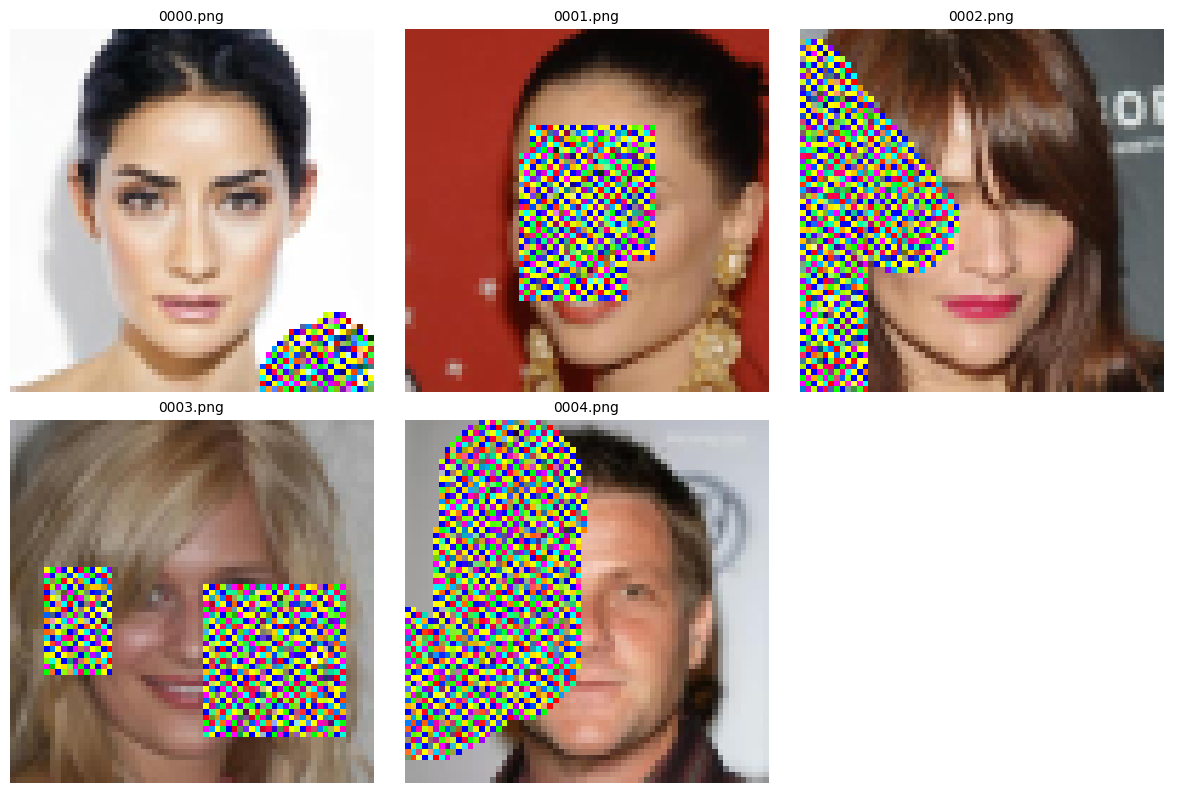

In [63]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import math

# Define the path to the outImg folder
save_dir = "/kaggle/working/p2w/logs/coarseImg"  # Replace with your args.save_dir
out_img_dir = save_dir

# List all PNG files in the outImg directory
image_files = sorted([f for f in os.listdir(out_img_dir) if f.endswith(".png")])
print(f"Found {len(image_files)} images in {out_img_dir}")

# Define the grid size (e.g., 2 rows x 3 columns for 6 images)
num_images = len(image_files)
cols = 3  # Number of columns in the grid
rows = math.ceil(num_images / cols)  # Calculate rows needed

# Create a figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

# Flatten axes array for easy iteration (handles both 1D and 2D cases)
axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes

# Load and plot each image
for idx, image_file in enumerate(image_files):
    if idx >= len(axes):  # Stop if we run out of grid spaces
        break
    # Load the image
    image_path = os.path.join(out_img_dir, image_file)
    img = Image.open(image_path)
    
    # Display the image in the grid
    axes[idx].imshow(img)
    axes[idx].set_title(image_file, fontsize=10)
    axes[idx].axis("off")  # Hide axes for cleaner display

# Hide any unused subplots
for idx in range(len(image_files), len(axes)):
    axes[idx].axis("off")

# Adjust layout and display the grid
plt.tight_layout()
plt.show()
